# Marketing Email Campaign Analysis

## Goal

Optimizing marketing campaigns is a common task in data science, and utilizing email as a tool is one of the most effective methods. Emails are cost-effective and can be easily personalized, making them a valuable asset in marketing efforts. To optimize email campaigns, machine learning can be utilized to personalize elements such as the text and subject line, as well as determining the target audience and optimal send time.

The e-commerce site's marketing team has recently launched an email campaign, targeting a random sample of users who have previously created an account on the site. The email informed recipients about a new feature on the site and the success of the campaign was measured by the number of users who clicked on the link within the email, which directed them to the company's website.

<span class="mark">Our task is to:</span>
* Analyze the performance of the email campaign and extract some useful insights. 
* Our objective is to create a click prediction model that will predict the probability of customers clicking on the link within an email. The ultimate goal of this model is to optimize future marketing campaigns by better targeting 'important' customers and allocating marketing efforts more effectively.

## Data

***email_table***

* email_id : the Id of the email that was sent. It is unique by email
* email_text : there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)
* email_version : some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were
"generic" (the incipit was just "Hi,").
* hour : the user local time when the email was sent.
* weekday : the day when the email was sent.
* user_country : the country where the user receiving the email was based. It comes from the user ip address when she created the account.
* user_past_purchases : how many items in the past were bought by the user receiving the email

***email_opened_table***

* email_id : the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it.

***link_clicked_table***
* email_id : if the user clicked on the link within the email, then the id of the email shows up on this table.

# Load data and libraries

In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings.filterwarnings('ignore')

In [608]:
email = pd.read_csv('email_table.csv')
email_open = pd.read_csv('email_opened_table.csv')
link_click = pd.read_csv('link_clicked_table.csv')

In [609]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [610]:
email_open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [611]:
link_click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


**Merge three data tables**

In [612]:
email_open['email_open'] = 1
link_click['email_link'] = 1

In [613]:
df = pd.merge(email, email_open, on='email_id', how='left', suffixes=('_email', '_email_open'))
df = pd.merge(df, link_click, on='email_id', how='left', suffixes=('_email', '_link_click'))

In [614]:
df.fillna(0,inplace=True)

In [615]:
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,email_link
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


# 1. Exploratory data analysis

## 1.1 Email open rate and click rate

In [616]:
open_rate = df['email_open'].value_counts()[1]/df['email_open'].value_counts().sum()
print(f'{open_rate*100} % of users opened the email')

10.345 % of users opened the email


In [617]:
click_rate = df['email_link'].value_counts()[1]/df['email_link'].value_counts().sum()
print(f'{click_rate*100} % of users opened the email')

2.119 % of users opened the email


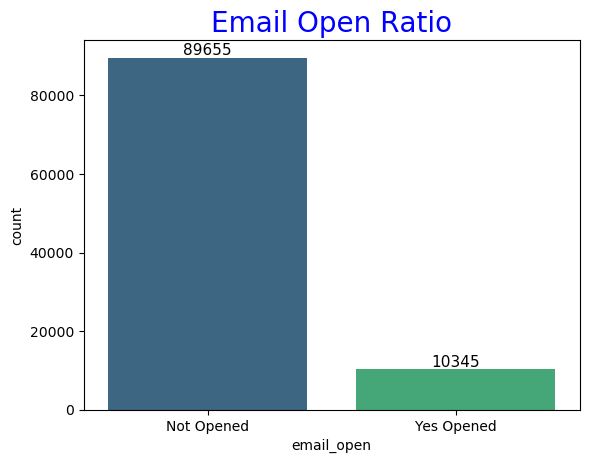

In [618]:
ax = sns.countplot(data=df, x='email_open',palette='viridis')
# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
ax.set_xticklabels(['Not Opened','Yes Opened'])

# Add a title and x-axis label
plt.title('Email Open Ratio', size=20, color='blue');

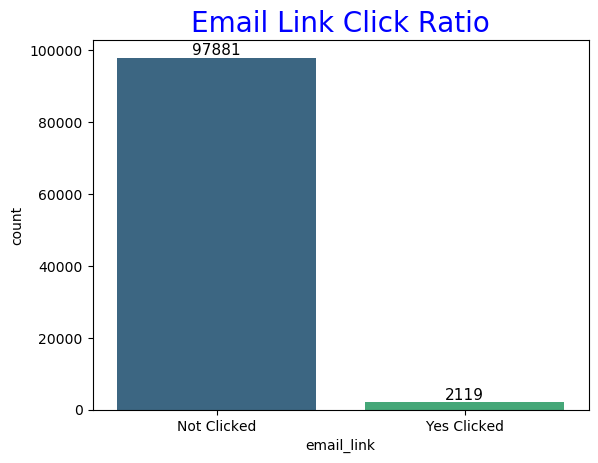

In [619]:
ax = sns.countplot(data=df, x='email_link',palette='viridis')
# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
ax.set_xticklabels(['Not Clicked','Yes Clicked'])

# Add a title and x-axis label
plt.title('Email Link Click Ratio', size=20, color='blue');

## 1.2 Email Text

In [620]:
click = df.groupby('email_text')['email_link'].agg(num_click = 'sum').reset_index()
open_ = df.groupby('email_text')['email_open'].agg(num_open = 'sum').reset_index()
pd.merge(click,open_)

,email_text,num_click,num_open
0,long_email,932.0,4584.0
1,short_email,1187.0,5761.0


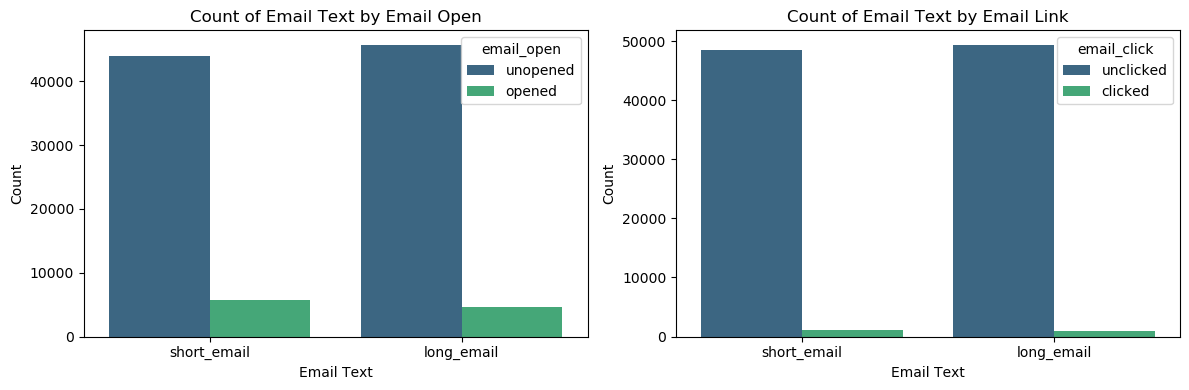

In [621]:
fig = plt.figure(figsize=(12,4))

# create first subplot
ax = plt.subplot(1, 2, 1)
sns.countplot(data=df, x='email_text',hue='email_open',palette='viridis')
plt.title('Count of Email Text by Email Open')
plt.xlabel('Email Text')
plt.ylabel('Count')
plt.legend(labels=['unopened','opened'],title='email_open')

# create second subplot
ax = plt.subplot(1, 2, 2)
sns.countplot(data=df, x='email_text',hue='email_link',palette='viridis')
plt.title('Count of Email Text by Email Link')
plt.xlabel('Email Text')
plt.ylabel('Count')
plt.legend(labels=['unclicked','clicked'],title='email_click')

plt.tight_layout()

**Insights**:
* Using shorter emails may be more effective in terms of getting them opened and clicked by the recipients. It implies that shorter emails are more likely to grab the attention of the recipients and generate more engagement. This information can be used to inform email marketing strategies by prioritizing shorter emails or by experimenting with the length of emails to see what resonates with the target audience.
* Additionally, it could also suggest that shorter emails are more likely to be read on mobile devices, where shorter messages are more suitable to the format. This could be particularly useful for businesses that are targeting customers who are likely to be using mobile devices to access their emails.

## 1.3 Email Version¶

In [622]:
click = df.groupby('email_version')['email_link'].agg(num_click = 'sum').reset_index()
open_ = df.groupby('email_version')['email_open'].agg(num_open = 'sum').reset_index()
pd.merge(click,open_)

,email_version,num_click,num_open
0,generic,760.0,3984.0
1,personalized,1359.0,6361.0


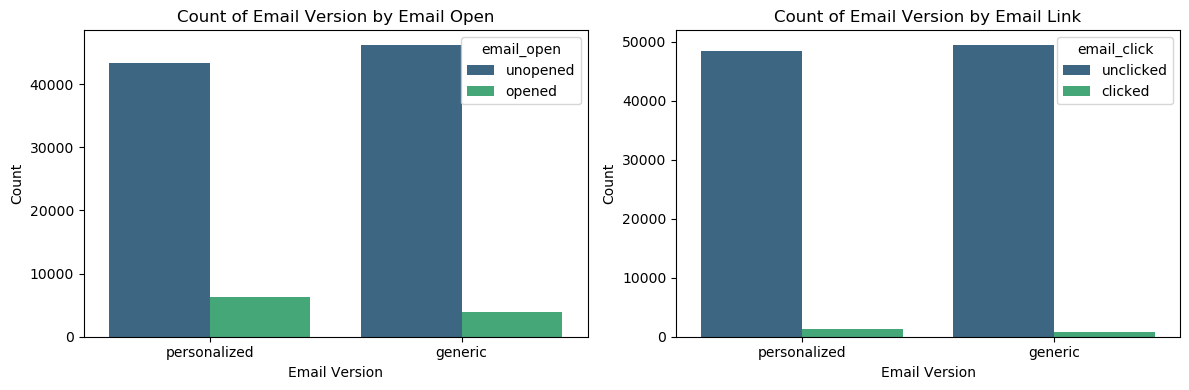

In [623]:
fig = plt.figure(figsize=(12,4))

# create first subplot
ax = plt.subplot(1, 2, 1)
sns.countplot(data=df, x='email_version',hue='email_open',palette='viridis')
plt.title('Count of Email Version by Email Open')
plt.xlabel('Email Version')
plt.ylabel('Count')
plt.legend(labels=['unopened','opened'],title='email_open')

# create second subplot
ax = plt.subplot(1, 2, 2)
sns.countplot(data=df, x='email_version',hue='email_link',palette='viridis')
plt.title('Count of Email Version by Email Link')
plt.xlabel('Email Version')
plt.ylabel('Count')
plt.legend(labels=['unclicked','clicked'],title='email_click')

plt.tight_layout()


**Insights**:
* Recipients are more likely to engage with emails that are tailored to their specific interests or needs. This information can be used to inform email marketing strategies by prioritizing the use of personalized emails or experimenting with the level of personalization to see what resonates with the target audience. It could also suggest that by addressing the recipient by their name, or by mentioning a purchase they made in the past, or a product they looked at can increase the open and click rate.

## 1.4 hour/weekday

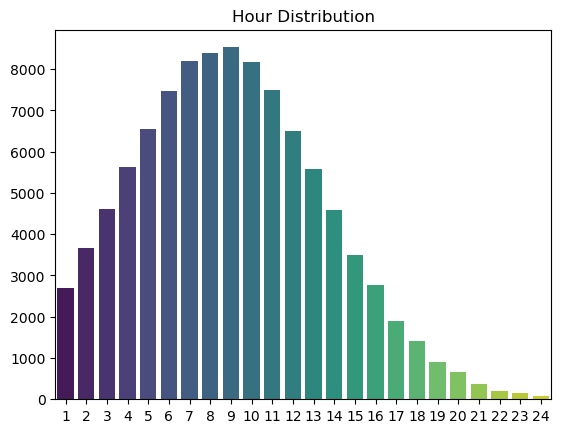

In [624]:
hr_tb = df['hour'].value_counts().to_frame().reset_index().sort_values(by='index')
sns.barplot(data=hr_tb, x='index',y='hour',palette='viridis')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Hour Distribution');


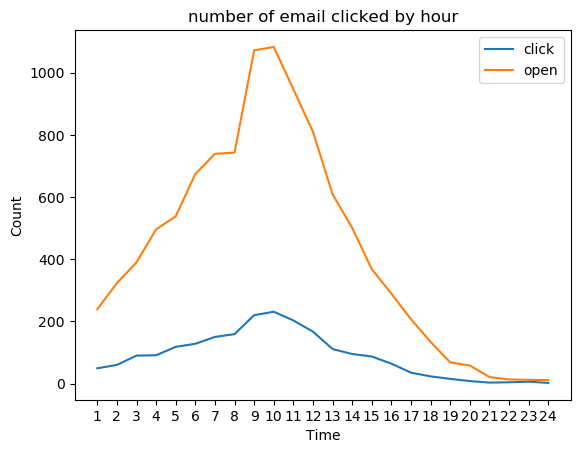

In [625]:
# Group the data by 'hour' and calculate the sum of 'email_link' and 'email_open'
email_link_by_hour = df.groupby('hour')['email_link'].sum()
email_open_by_hour = df.groupby('hour')['email_open'].sum()

# Plot charts
plt.plot(email_link_by_hour,label='click')
plt.plot(email_open_by_hour,label='open')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(range(1,25))
plt.title('number of email clicked by hour')
plt.legend()



**Insights**:
* By sending emails during the time frame of 8am to 2pm, we can expect to see a higher click and open rate, as this is when recipients are most likely to check and engage with their emails.
* We will be utilizing Machine Learning techniques to analyze and optimize the timing of our emails. By analyzing data on when emails were sent in the past and corresponding click and open rates, we can determine the most effective time frame for sending emails. 

In [626]:
t1 = df.groupby('weekday')['email_link'].agg(num_email='count').reset_index()
t = df.groupby('weekday')['email_link','email_open'].agg({'email_open':'sum','email_link':'sum'}).reset_index()
tb = pd.merge(t1,t)


In [627]:
weekdays = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]
tb['weekday_rank'] = tb['weekday'].apply(lambda x: weekdays.index(x))
tb = tb.iloc[tb['weekday_rank'].argsort()]

In [628]:
tb

,weekday,num_email,email_open,email_link,weekday_rank
1,Monday,14363,1667.0,329.0,0
5,Tuesday,14143,1704.0,352.0,1
6,Wednesday,14084,1694.0,389.0,2
4,Thursday,14277,1691.0,349.0,3
0,Friday,14177,1051.0,199.0,4
2,Saturday,14569,1277.0,260.0,5
3,Sunday,14387,1261.0,241.0,6


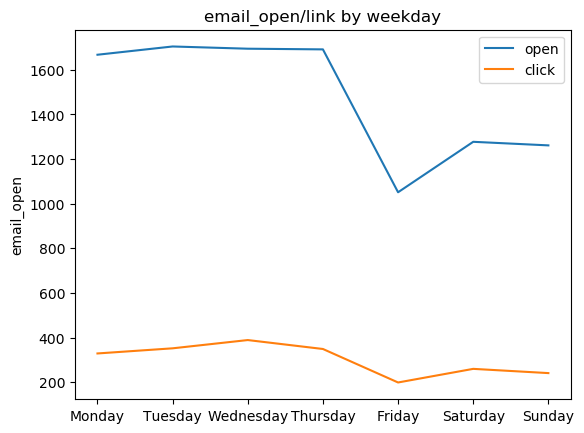

In [629]:
sns.lineplot(data=tb,x='weekday',y='email_open',label='open')
sns.lineplot(data=tb,x='weekday',y='email_link',label='click')
plt.title('email_open/link by weekday')
plt.xlabel(None);

**Insights**:
* Emails sent on Friday have the lowest open rate, suggesting that Friday may not be the best day to send emails for engagement.
* The number of email links clicked on Wed is the highest among all weekdays, indicating that Wed may be a good day to send emails with links for maximum click-through rate.
* The open rate and click-through rate on Thursdays is higher compared to Fridays, suggesting that Thursdays could be more effective for email marketing campaigns.
* Overall, Monday to Thursday are good days to send emails for high open and click-through rate.
* The emails sent on weekends have lower open and click-through rate, which may indicate that people are less likely to check their emails on weekends.

## 1.5 User_country

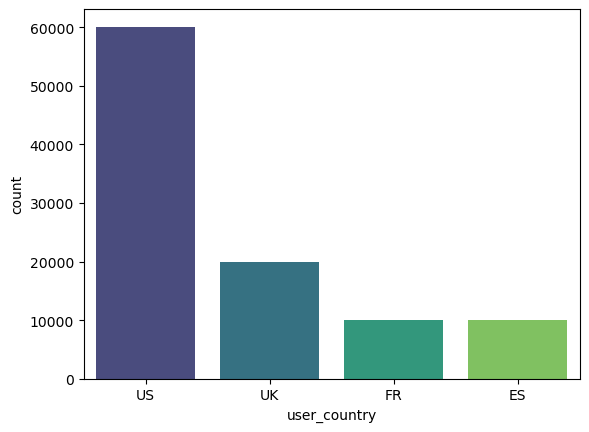

In [630]:
sns.countplot(data=df,x='user_country',palette='viridis');

In [631]:
t1 = df.groupby('user_country')['email_link'].agg(num_email='count').reset_index()
t = df.groupby('user_country')['email_link','email_open'].agg({'email_open':'sum','email_link':'sum'}).reset_index()
tb = pd.merge(t1,t)
tb


,user_country,num_email,email_open,email_link
0,ES,9967,390.0,83.0
1,FR,9995,406.0,80.0
2,UK,19939,2396.0,492.0
3,US,60099,7153.0,1464.0


Since the num_email is different across countries,to compare the email open and link rates between countries fairly, we should calculate the open and link rate as a percentage of the number of emails sent to that country. This will account for the differences in the number of emails sent to each country and allow for a fair comparison.

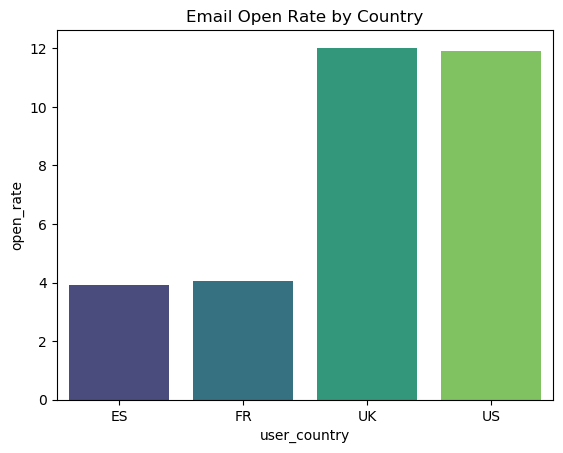

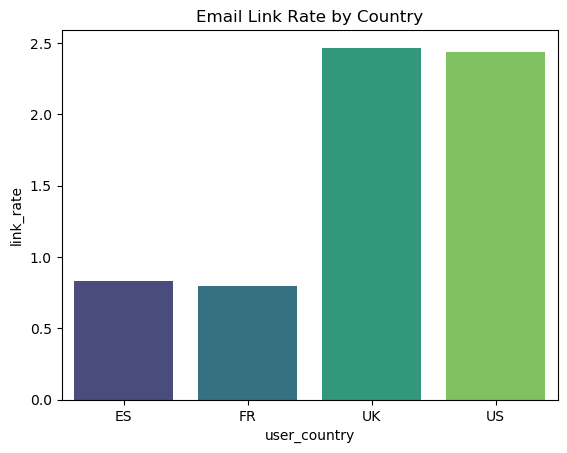

In [632]:
# Calculate the open and link rate as a percentage of the number of emails sent
tb['open_rate'] = tb['email_open'] / tb['num_email'] * 100
tb['link_rate'] = tb['email_link'] / tb['num_email'] * 100

# Create a bar chart of the open rate by country
sns.barplot(data=tb, x='user_country', y='open_rate', palette='viridis')
plt.title('Email Open Rate by Country')
plt.show()

# Create a bar chart of the link rate by country
sns.barplot(data=tb, x='user_country', y='link_rate', palette='viridis')
plt.title('Email Link Rate by Country')
plt.show()


**Insights**:
* It seems that the UK and US have higher open and link rates compared to ES and FR. This indicates that the email marketing campaigns in the UK and US are more effective in terms of getting recipients to open and click on the emails. This could be due to a variety of factors such as the target audience, the messaging, the email design, or the timing of the emails. 
* It would be interesting to drill down further and understand the underlying reasons for this difference in performance, this might be done by analyzing the other variables in the dataset, such as email_text, email_version, hour and weekday, and also, by comparing the demographics of the audience in each country.

## 1.6 User Past Purchase

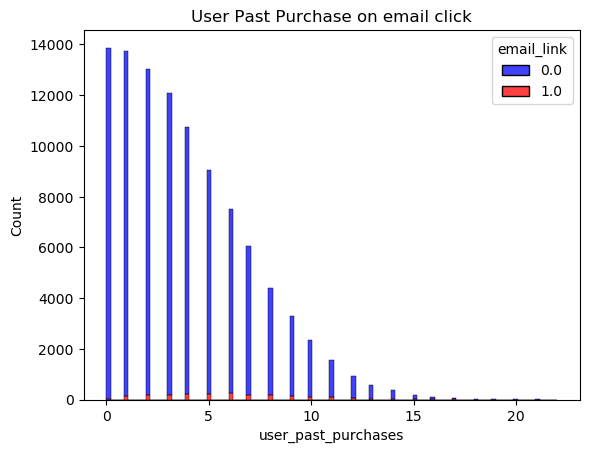

In [633]:
# Create the histogram
sns.histplot(data=df, x='user_past_purchases', hue='email_link', multiple='stack', palette={1: 'red', 0: 'blue'})
plt.title('User Past Purchase on email click')

# Get the data for the email link = 1
email_link_1 = df[df['email_link'] == 1]

# Get the x and y coordinates for the email link = 1 data
x = email_link_1['user_past_purchases']
y = email_link_1['email_link']


# Show the plot
plt.show()


**Insights**:
* The data suggests that as the number of past purchases increase, the click rate also increases. It appears that individuals who have made past purchases are more likely to engage with the emails by clicking on the links. On the other hand, individuals who have not made any past purchases have a significantly lower click rate. This implies that individuals who have already made purchases with the company may be more likely to be interested in future promotions and offers.

# 2. Feature Engineering

## Feature Engineering

In [634]:
# we should drop email open because it is obvious you need to open the email so that you can click
X = df.drop(['email_id', 'email_link','email_open'], axis=1)
y = df['email_link']

Since the relationship between hour and click rate might not be linear, we could categorize hour into different time block.

In [635]:
bin_edges = [0, 6, 12, 18, 24]
bin_names = ['midnight', 'morning', 'afternoon', 'evening']

# Create a new column 'time_of_day' with the binned hour values
X['time_of_day'] = pd.cut(X['hour'], bin_edges, labels=bin_names)
X['time_of_day'] = X['time_of_day'].astype('object')
X.drop('hour',axis=1,inplace=True)

#add intercept for multiple logistc regression
X['intercept'] = 1

Get dummies

In [636]:
X_category = X.select_dtypes(['object']).astype('category')
print('These are the reference levels') 
print('----------------------------') 
X_category.apply(lambda x: x.cat.categories[0])

These are the reference levels
----------------------------


email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
time_of_day       afternoon
dtype: object

In [637]:
X_dummies = pd.get_dummies(data=X,
                           columns=[
                               'email_text', 'email_version', 'weekday',
                               'user_country', 'time_of_day'
                           ],
                           drop_first=True)

# 3. Insights Extraction using Machine Learning

## PCA

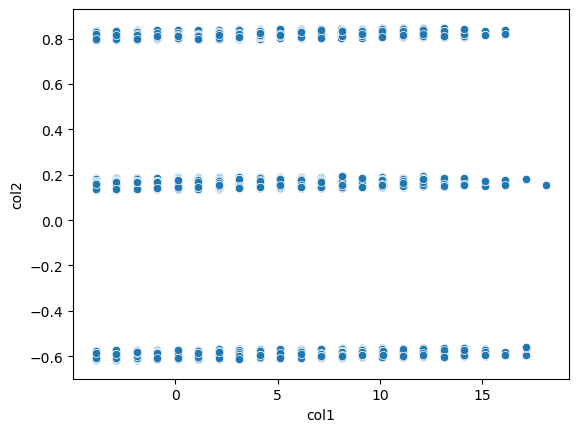

In [742]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=2)
pca.fit(X_dummies)
PCA_ds = pd.DataFrame(pca.transform(X_dummies), columns=(["col1","col2"]))
PCA_ds.describe().T

a =PCA_ds["col1"]
b =PCA_ds["col2"]

sns.scatterplot(a,b);

In [749]:
print(pca.explained_variance_ratio_.cumsum())

[0.82217097 0.85251255]


**Insights**
* When we check the explained variance ratio or cumulative explained variance ratio of a PCA, it gives us an idea of how much of the total variance in the dataset is explained by each principal component. If a high proportion of the variance is explained by a small number of principal components, it means that these components contain most of the information in the dataset.
* In our case, the first two component alone explains around 85% of the variance in the dataset, suggesting that PCA is effectively reducing the dimensionality of the data and capturing a large proportion of the information in the original dataset in these principal components.

## Clustering

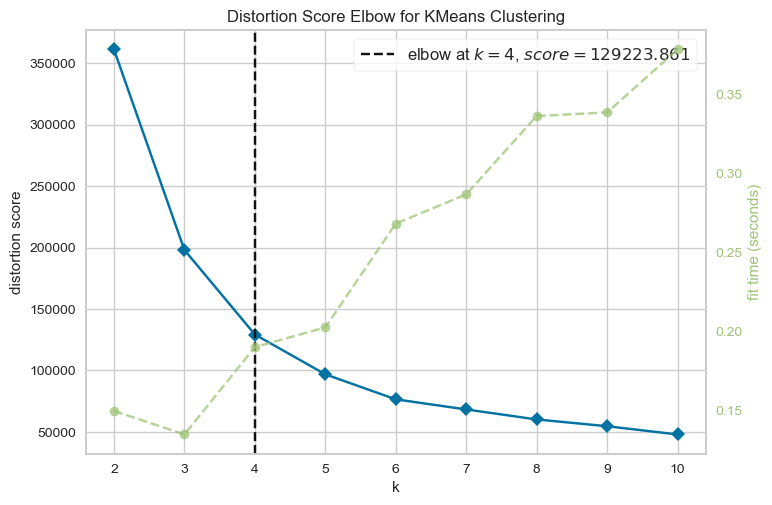

In [776]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# Quick examination of elbow method to find numbers of clusters to make.
Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show();

In [777]:
clus = df.copy()

#Initiating the Agglomerative Clustering model 
AC = KMeans(n_clusters=4) # elbow = 4
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
clus["Clusters"]= yhat_AC

In [778]:
PCA_ds.sample(5)

,col1,col2,Clusters
62349,-0.878563,-0.598139,2
16818,1.120734,0.800609,2
81967,3.121553,-0.604762,1
57004,5.120859,0.835459,1
5204,-1.878693,0.143136,0


In [779]:
clus.sample(5)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,email_link,Clusters
95549,872432,short_email,personalized,4,Saturday,US,1,0.0,0.0,0
16961,676403,long_email,personalized,14,Sunday,US,0,0.0,0.0,0
71116,559951,short_email,personalized,11,Saturday,US,1,0.0,0.0,0
81324,636472,short_email,generic,2,Thursday,US,1,0.0,0.0,0
88802,955636,long_email,personalized,12,Friday,ES,4,0.0,0.0,2


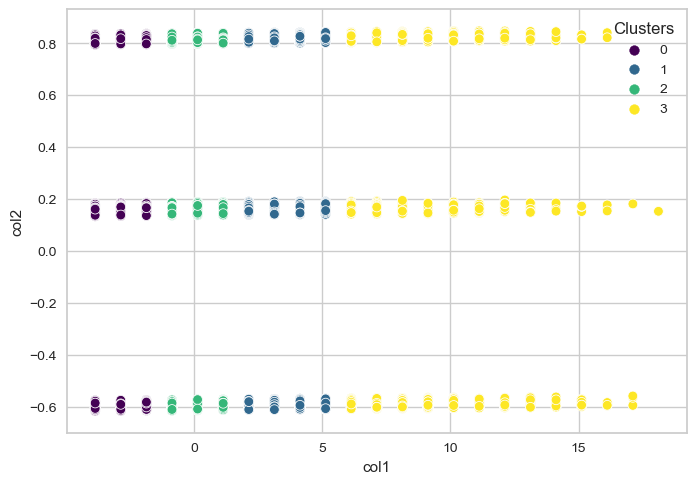

In [782]:
sns.scatterplot(a,b,hue=PCA_ds['Clusters'],palette='viridis')

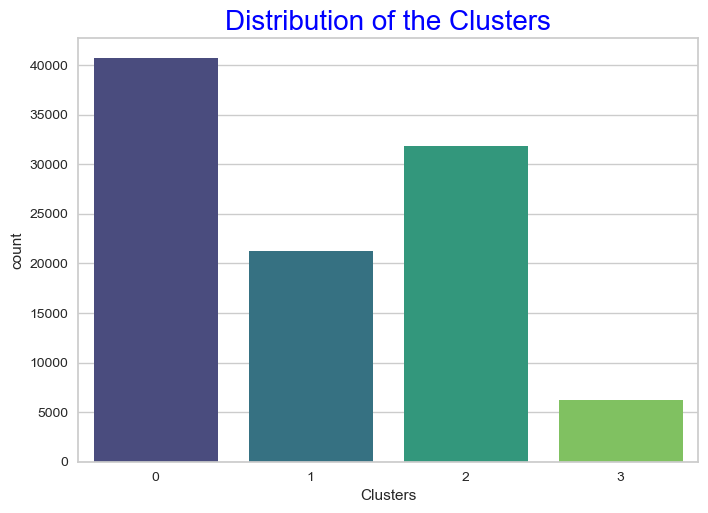

In [809]:
sns.countplot(x=clus["Clusters"], palette='viridis')
plt.title("Distribution of the Clusters",size=20,color='blue');

**Insights**:
* Based on the plots, it appears that cluster 3 has the highest click rate on the email links, indicating that these customers are most likely to click on the links, even though they are not the majority of the total customers.

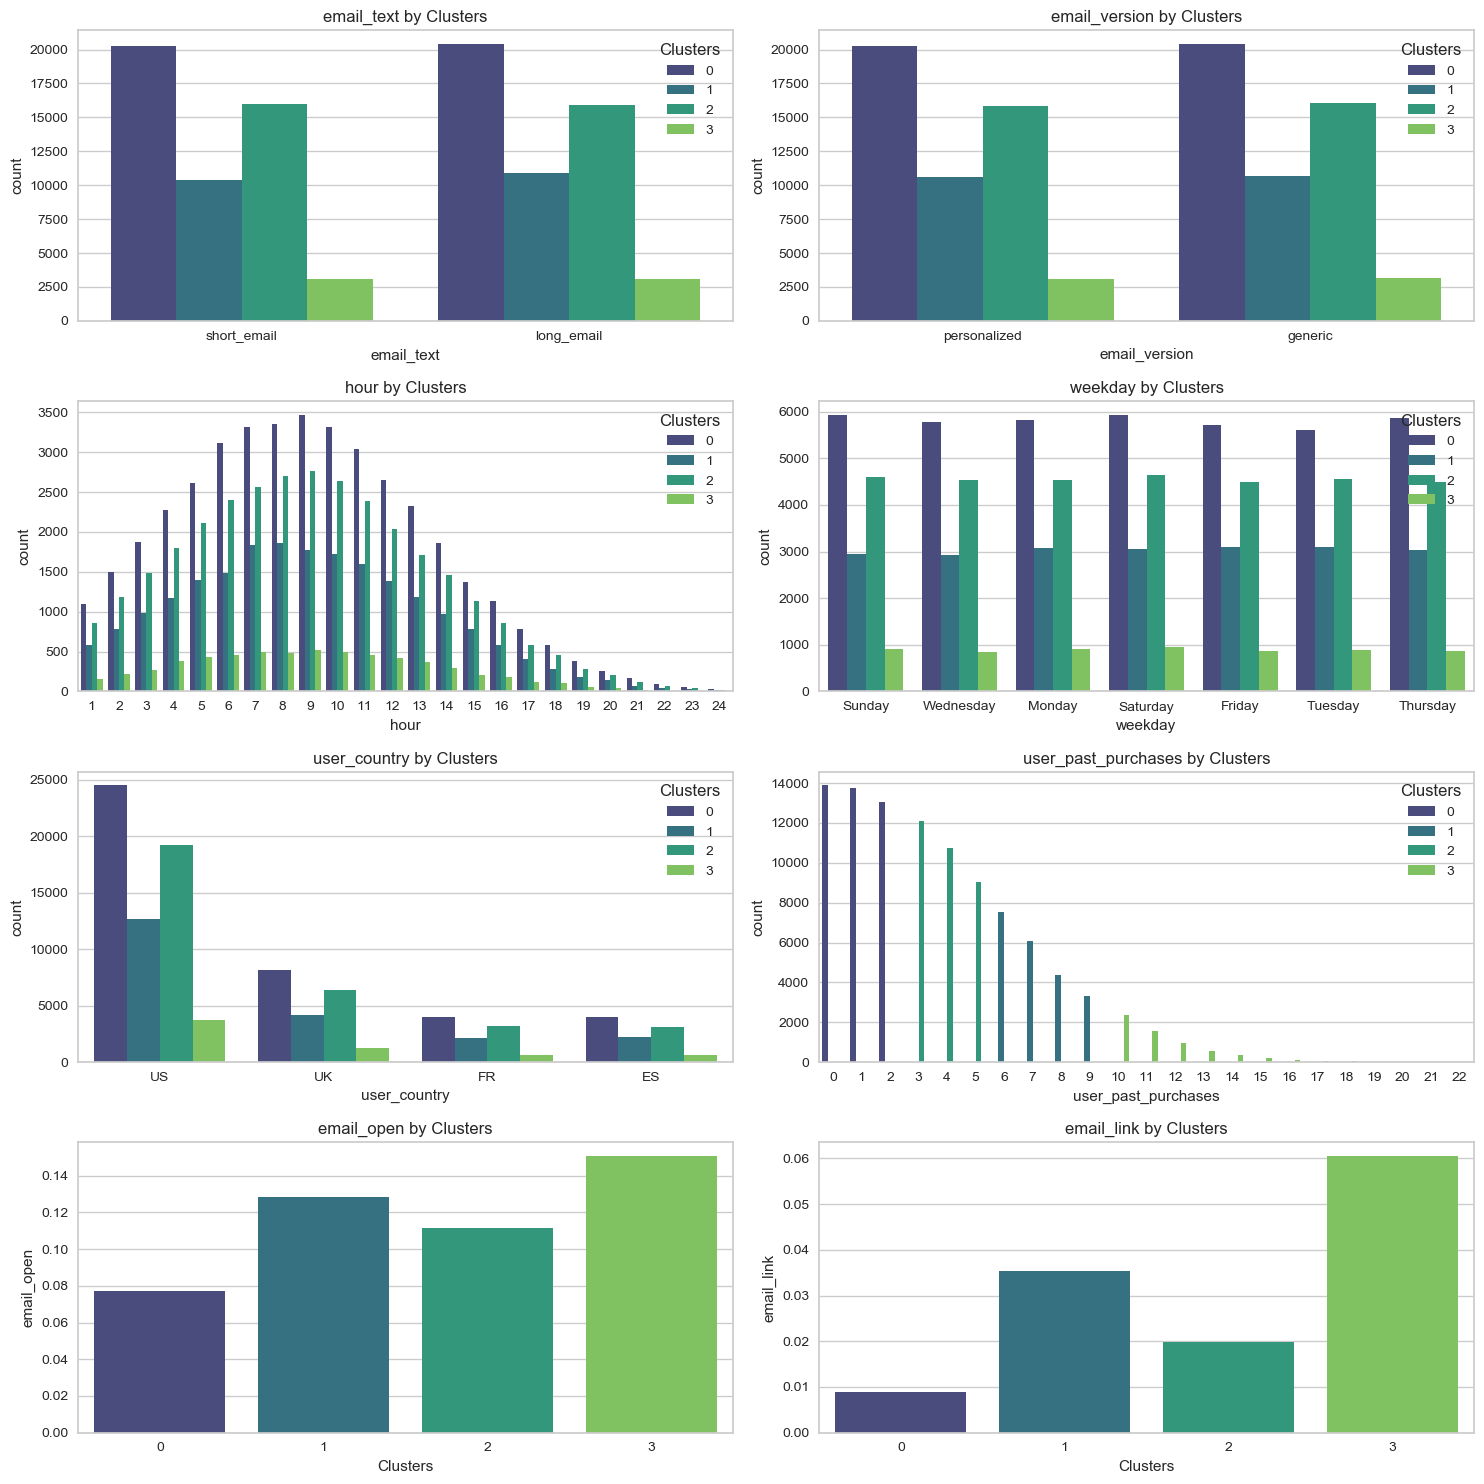

In [804]:
columns = ['email_text', 'email_version', 'hour', 'weekday','user_country', 'user_past_purchases', 'email_open', 'email_link']

# Set the number of rows and columns for the subplots
nrows = 4
ncols = 2

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Flatten the axes object to a single list of axes
axs = axs.flatten()

# Iterate over the columns and plot each one
for ax, column in zip(axs, columns):
    if column in ['email_open', 'email_link']:
        sns.barplot(y=column, x='Clusters', data=clus, palette='viridis', ax=ax,ci=None)
    else:
        sns.countplot(x=column, hue='Clusters', data=clus, palette='viridis', ax=ax)
    ax.set_title(f"{column} by Clusters")

# Tighten the layout 
plt.tight_layout()
plt.show()


**Insights**:
* Clusters three has the highest click rate, followed by clusters one and two, while cluster zero has the lowest click rate.
* From the plots, it appears that the distribution of clusters is relatively similar across different features, except for the user_past_purchases feature. In general, the more products a customer has purchased in the past, the more likely they are to be engaged with the company's products, and therefore more likely to click on the email links.

To further investigate the relationships of each variable's impact on click rate, Tree-based models such as Random Forest, and Gradient Boosting, Logistic Regression, and RuleFit algorithm could be used.

* `Logistic Regression`: This algorithm can be used to model the relationship between the input variables and the click rate. It will give you a clear idea of the magnitude and direction of the effect of each variable on the click rate.

* `Tree-based models`: These models can be used to identify the most important features that are impacting the click rate. It will give you a clear idea of which variables are contributing the most to the click rate and how they are interacting with each other.

* `PDP (Partial Dependence Plot)`: These plots can be used to visualize the relationship between the input variables and the click rate. It will help you to understand how changing a variable's value affects the click rate.

* `RuleFit algorithm`: This algorithm can be used to identify the most important features that are impacting the click rate and generate human-readable rules for the predictions.

## Logistic Regression

In [638]:
import statsmodels.api as sm

In [639]:
#first model

logit_1 = sm.Logit(y, X_dummies).fit()
output_table = pd.DataFrame(
    dict(coefficients=logit_1.params,
         SE=logit_1.bse,
         z=logit_1.tvalues,
         p_values=logit_1.pvalues))

Optimization terminated successfully.
         Current function value: 0.094787
         Iterations 9


In [640]:
output_table

,coefficients,SE,z,p_values
user_past_purchases,0.183983,0.005678,32.403320,2.464484e-230
intercept,-6.630078,0.147530,-44.940501,0.000000e+00
email_text_short_email,0.265615,0.044730,5.938218,2.881365e-09
email_version_personalized,0.609198,0.046180,13.191915,9.767172e-40
weekday_Monday,0.492356,0.091375,5.388318,7.111997e-08
weekday_Saturday,0.241884,0.095685,2.527919,1.147407e-02
weekday_Sunday,0.177124,0.097253,1.821275,6.856499e-02
weekday_Thursday,0.566340,0.090409,6.264187,3.747756e-10
weekday_Tuesday,0.572988,0.090301,6.345291,2.220060e-10
weekday_Wednesday,0.712126,0.088785,8.020781,1.050749e-15


Filter out p value that are more than 0.05

In [641]:
# select predictor variables with p-value < 0.05
significant_vars = output_table[output_table['p_values'] < 0.05]

# create a new dataframe with only significant predictor variables
X_significant = X_dummies[significant_vars.index]

# refit the logistic regression model with only significant predictor variables
logit_2 = sm.Logit(y, X_significant).fit()

output_table = pd.DataFrame(
    dict(coefficients=logit_2.params,
         SE=logit_2.bse,
         z=logit_2.tvalues,
         p_values=logit_2.pvalues))


Optimization terminated successfully.
         Current function value: 0.094818
         Iterations 9


In [642]:
output_table

,coefficients,SE,z,p_values
user_past_purchases,0.184008,0.005678,32.406291,2.238133e-230
intercept,-6.582543,0.113046,-58.228645,0.000000e+00
email_text_short_email,0.265571,0.044726,5.937690,2.890662e-09
email_version_personalized,0.609581,0.046176,13.201210,8.633692e-40
weekday_Monday,0.399425,0.074347,5.372481,7.766072e-08
weekday_Saturday,0.148659,0.079586,1.867911,6.177444e-02
weekday_Thursday,0.473748,0.073159,6.475574,9.445193e-11
weekday_Tuesday,0.479444,0.073022,6.565748,5.177246e-11
weekday_Wednesday,0.618660,0.071141,8.696290,3.429128e-18
user_country_UK,1.159387,0.091509,12.669668,8.708230e-37


Keep filtering

In [643]:
# select predictor variables with p-value < 0.05
significant_vars = output_table[output_table['p_values'] < 0.05]

# create a new dataframe with only significant predictor variables
X_significant = X_dummies[significant_vars.index]

# refit the logistic regression model with only significant predictor variables
logit_3 = sm.Logit(y, X_significant).fit()

output_table = pd.DataFrame(
    dict(coefficients=logit_3.params,
         SE=logit_3.bse,
         z=logit_3.tvalues,
         p_values=logit_3.pvalues))


Optimization terminated successfully.
         Current function value: 0.094835
         Iterations 9


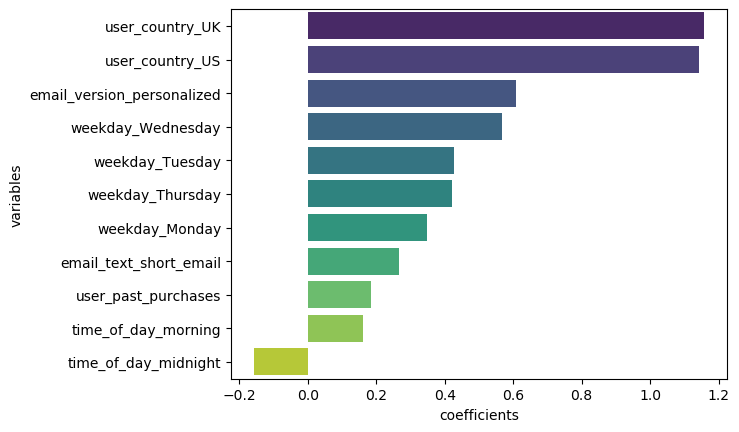

In [644]:
plot_tb = output_table[output_table.index != 'intercept']
plot_tb = plot_tb.reset_index().sort_values(by='coefficients',ascending=False)
plot_tb.rename(columns = {'index':'variables'},inplace=True)

sns.barplot(data=plot_tb,
            y='variables',
            x='coefficients',
            palette='viridis');


In [645]:
plot_tb[['variables','coefficients']]

,variables,coefficients
7,user_country_UK,1.158830
8,user_country_US,1.142287
2,email_version_personalized,0.609289
6,weekday_Wednesday,0.566040
5,weekday_Tuesday,0.426823
4,weekday_Thursday,0.421139
3,weekday_Monday,0.346801
1,email_text_short_email,0.265801
0,user_past_purchases,0.184097
10,time_of_day_morning,0.160492


**what is odd?**
odds = P(event occurring) / P(event not occurring)

* The log odds is a measure of the odds of an outcome occurring. The odds is defined as the probability of the outcome occurring divided by the probability of the outcome not occurring.

* A log odds of 0 indicates that the odds of the outcome occurring are equal to the odds of the outcome not occurring. In other words, there is an equal chance of the outcome occurring or not occurring.

* A positive log odds indicates that the odds of the outcome occurring are greater than the odds of the outcome not occurring. In other words, there is a higher probability of the outcome occurring.

* A negative log odds indicates that the odds of the outcome occurring are less than the odds of the outcome not occurring. In other words, there is a lower probability of the outcome occurring.

* The magnitude of the log odds tells you the strength of the relationship between the predictor variable and the outcome. For example, a log odds of 1 is stronger than a log odds of 0.5, which is in turn stronger than a log odds of 0.1.

**Insights**:
* The coefficients of a logistic regression model represent the change in the log odds of the response variable for a one-unit change in the predictor variable, while holding all other predictor variables constant.
* In this specific case, the logistic regression model is being used to predict the probability of a user opening an email based on various features such as email_text, email_version, weekday, user_country, user_past_purchases and time_of_day.
* From a business perspective, the coefficients of the model can help to understand which variables have the most impact on the probability of the user opening the email.
    * `user_country_UK`: This variable has a coefficient of 1.158830, which tells us that, on average, for users from UK, the log odds of the user opening the email increases by 1.158830 (holding all other predictor variables constant) compared to users from US. From a business perspective, this suggests that targeting users from the UK might be a good strategy for increasing the chances of the user opening the email. This could be achieved by targeting users from the UK with special promotions or offers, or by tailoring the content of the emails to be more relevant to users from the UK. Additionally, the business could also investigate why the open rate is higher for UK users and replicate those factors for other countries.
    * `email_version_personalized`: This variable has a coefficient of 0.609289, which tells us that, on average, for personalized emails, the log odds of the user opening the email increases by 0.609289 (holding all other predictor variables constant) compared to generic emails. From a business perspective, this suggests that personalizing emails might be a good strategy for increasing the chances of the user opening the email. This could be achieved by using the user's name, browsing history, purchase history, or other information to tailor the content of the email to the user's interests. Additionally, the business could also test different levels of personalization to see which level works best for their user base.
    * `weekday_Wednesday, weekday_Tuesday and weekday_Thursday`: These variables have coefficients of 0.566040, 0.426823, 0.421139 respectively, which tells us that, on average, for emails sent on Wednesday, Tuesday and Thursday, the log odds of the user opening the email increases (holding all other predictor variables constant) compared to emails sent on other days of the week. From a business perspective, this suggests that sending emails on Wednesdays, Tuesdays, and Thursdays might be a good strategy for increasing the chances of the user opening the email. The business could investigate the reasons for this pattern, for example, if users are more likely to check their email on these days or if they are more likely to have free time to engage with the email. Additionally, the business could also test sending emails on other days of the week to see if the open rate changes.
    * `email_text_short_email`: This variable has a coefficient of 0.265801, which tells us that, on average, for emails with short text, the log odds of the user opening the email increases by 0.265801 (holding all other predictor variables constant) compared to emails with long text. From a business perspective, this suggests that using shorter emails might be a good strategy for increasing the chances of the user opening the email. This could be achieved by keeping the emails concise and to the point, focusing on the most important information, and using clear and concise language. Additionally, the business could also test different lengths of emails and see which length works best for their user base.
    * `user_past_purchases`: This variable has a coefficient of 0.184097, which tells us that, on average, for each additional past purchase a user has, the log odds of the user opening the email increases by 0.184097 (holding all other predictor variables constant). From a business perspective, this suggests that targeting users who have made past purchases might be a good strategy for increasing the chances of the user opening the email. This could be achieved by sending targeted promotions or offers to users who have made past purchases, or by tailoring the content of the emails to be more relevant to these users. Additionally, the business could also investigate why the open rate is higher for users with more past purchases and replicate those factors for other users.
    * `time_of_day_morning and time_of_day_midnight`: These variables have coefficients of 0.160492 and -0.158584 respectively, which tells us that, on average, for emails sent at morning, the log odds of the user opening the email increases by 0.160492 (holding all other predictor variables constant) compared to emails sent at midnight. From a business perspective, this suggests that targeting users at morning might be a good strategy for increasing the chances of the user opening the email. This could be achieved by scheduling emails to be sent during the morning hours, when users are likely to be checking their email, or by tailoring the content of the emails to be more relevant to the users at that time. Additionally, the business could also test sending emails at different times of the day to see if the open rate changes.



## Decision Tree

In [646]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import Source
from sklearn.tree import _tree

In [647]:
y.value_counts()[1]/y.value_counts().sum()

0.02119

In [648]:
clf = DecisionTreeClassifier(class_weight={0:0.05,1:0.95},
                             min_impurity_decrease=0.001)
clf.fit(X_dummies, y)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95},
                       min_impurity_decrease=0.001)

In [649]:
tree.export_graphviz(clf,
                    out_file='tree.dot',
                    feature_names=X_dummies.columns.values,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    proportion=True,
                    rotate=True)

s = Source.from_file('tree.dot')

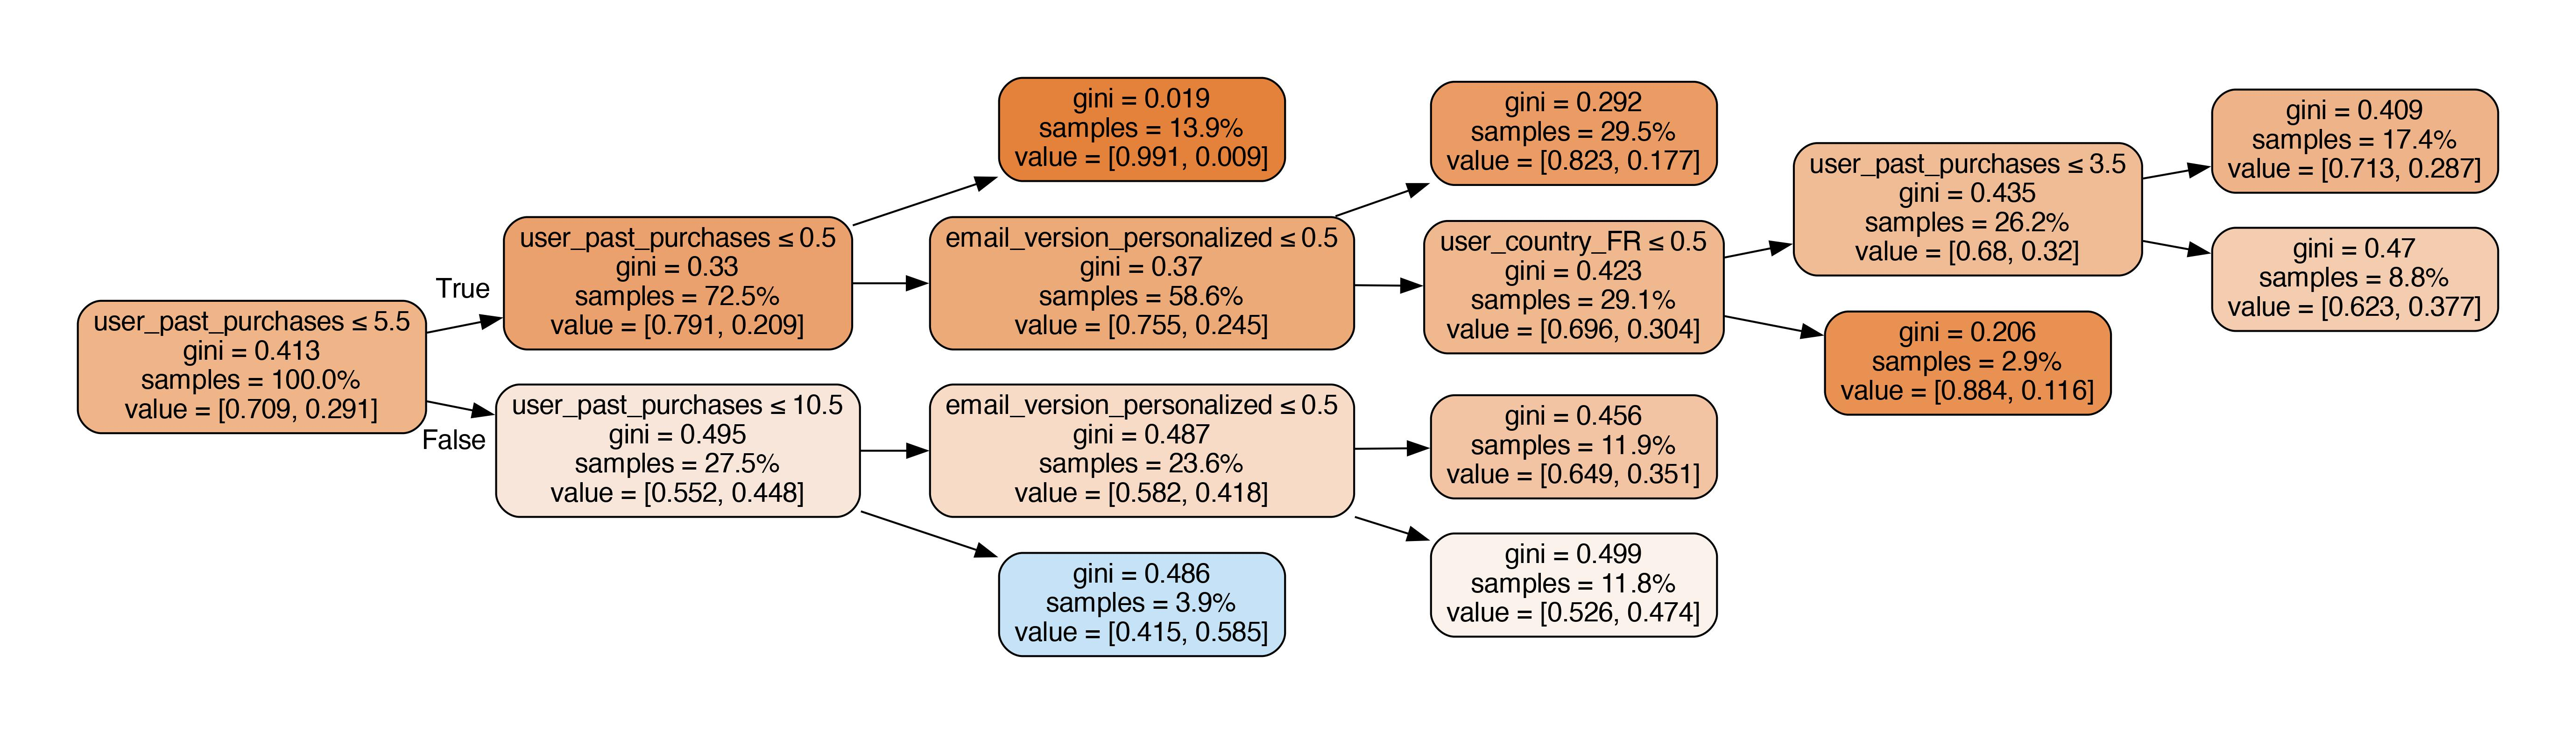

In [650]:
# to get human readable splits
# this extract all the rules plus leaf nodes
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [672]:
rules = get_rules(clf, X_dummies.columns.values, y)

In [660]:
data = []
for r in rules:
    first_column, second_column, third_column = r.split('then')[0], r.split('class:')[1].split('| based on')[0], r.split('based on')[1].split('samples')[0]
    data.append([first_column, second_column, third_column])
    
rules = pd.DataFrame(data, columns=['Rules', 'Class', 'Num_Samples'])


In [664]:
pd.set_option('display.max_colwidth',None)
rules

,Rules,Class,Num_Samples
0,if (user_past_purchases <= 5.5) and (user_past_purchases > 0.5) and (email_version_personalized <= 0.5),0.0 (proba: 82.27%),"29,513"
1,if (user_past_purchases <= 5.5) and (user_past_purchases > 0.5) and (email_version_personalized > 0.5) and (user_country_FR <= 0.5) and (user_past_purchases <= 3.5),0.0 (proba: 71.28%),"17,431"
2,if (user_past_purchases <= 5.5) and (user_past_purchases <= 0.5),0.0 (proba: 99.05%),"13,877"
3,if (user_past_purchases > 5.5) and (user_past_purchases <= 10.5) and (email_version_personalized <= 0.5),0.0 (proba: 64.91%),"11,856"
4,if (user_past_purchases > 5.5) and (user_past_purchases <= 10.5) and (email_version_personalized > 0.5),0.0 (proba: 52.59%),"11,765"
5,if (user_past_purchases <= 5.5) and (user_past_purchases > 0.5) and (email_version_personalized > 0.5) and (user_country_FR <= 0.5) and (user_past_purchases > 3.5),0.0 (proba: 62.27%),"8,801"
6,if (user_past_purchases > 5.5) and (user_past_purchases > 10.5),1.0 (proba: 58.49%),"3,853"
7,if (user_past_purchases <= 5.5) and (user_past_purchases > 0.5) and (email_version_personalized > 0.5) and (user_country_FR > 0.5),0.0 (proba: 88.36%),"2,904"


**Insights**:
* This segment represents users who have made a moderate number of past purchases and have a personalized email version. However, their likelihood to click on the email is still lower than other segments. To effectively target this segment, we should consider analyzing their past purchase behavior and identify what types of products or services they have shown interest in. By tailoring our offers or incentives to align with their interests, we can increase the chances of them engaging with our campaign. Additionally, we should also consider testing different email subject lines and layouts to see what resonates with this segment.
    * *`Rule 0`*: for those users who made between 0.5 and 5.5 purchases in the past and have a non-personalized email version, they are extremely unlikely to click on the email. This segment represents 29.513% of the total population. To effectively target this segment, we should focus on providing them with personalized content and incentives that align with their past purchase behavior and preferences.

    * `Rule 1`: for those users who made between 0.5 and 3.5 purchases in the past, have a personalized email version, and are not from France, they are also less likely to click on the email. This segment represents 17,431 users. To effectively target this segment, we should focus on understanding their past purchase behavior and identifying what types of products or services they have shown interest in. By tailoring our offers or incentives to align with their interests, we can increase the chances of them engaging with our campaign. Additionally, we should also consider experimenting with different email subject lines and layouts that may resonate with this segment.

    * `Rule 2`: Users who have made less than or equal to 0.5 purchases in the past are highly unlikely to click on the email. This segment represents 13,877 users. To effectively target this segment, we should consider not targeting them with this campaign, and instead, focus on other segments that are more likely to engage with our campaign.

    * `Rule 3`: Users who have made more than 5.5 but less than or equal to 10.5 purchases in the past and have a non-personalized email version are also less likely to click on the email. This segment represents 11,856 users. To effectively target this segment, we should focus on providing them with personalized content and incentives that align with their past purchase behavior and preferences.

    * `Rule 4`x: Users who have made more than 5.5 but less than or equal to 10.5 purchases in the past and have a personalized email version are also less likely to click on the email. This segment represents 11,765 users. To effectively target this segment, we should focus on providing them with personalized content and incentives that align with their past purchase behavior and preferences. Additionally, we can also consider offering them loyalty rewards or exclusive discounts to incentivize them to engage with our campaign.
    
    * `Rule 5`: Users who have made between 0.5 and 5.5 purchases in the past, have a personalized email version, are not from France and made more than 3.5 purchases, they are also less likely to click. There are 8,801 users in this segment, this segment represents users who have made a moderate number of past purchases, have a personalized email version but not from France and made more than 3.5 purchases. To target this segment effectively, we should consider analyzing their past purchase behavior and identifying what types of products or services they have shown interest in. Additionally, we should also consider testing different email subject lines and layouts to see what resonates with this segment. We can also offer them with special discounts or promotions that are specific to their country to increase their engagement.

    * `Rule 6`: for those users who made more than 10.5 purchases in the past, they are more likely to click on the email. There are 3,853 users in this segment, this segment represents users who are loyal customers and have a high potential of responding to our email campaign. To effectively target this segment, we should consider offering them exclusive deals or promotions that are not available to other segments. Additionally, we should also consider sending them personalized messages or greetings to further build a relationship with them.

    * `Rule 7`: for those users who made between 0.5 and 5.5 purchases in the past, have a personalized email version, and are from France, they are also highly unlikely to click. There are 2,904 users in this segment, this segment represents users who are not likely to engage with our campaign even though they have a personalized email version. To effectively target this segment, we should consider conducting more research on the specific reasons why they are not engaging with our emails and tailor our campaign accordingly.





## PDP

We will first build a black box algorithm (XG Boost) that predicts well and then apply PDP onto it

In [716]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

In [711]:
y.value_counts()[1]/y.value_counts().sum()

0.02119

**Search for the best cut-off point**

In [829]:
xgb = XGBClassifier().fit(X_dummies,y)

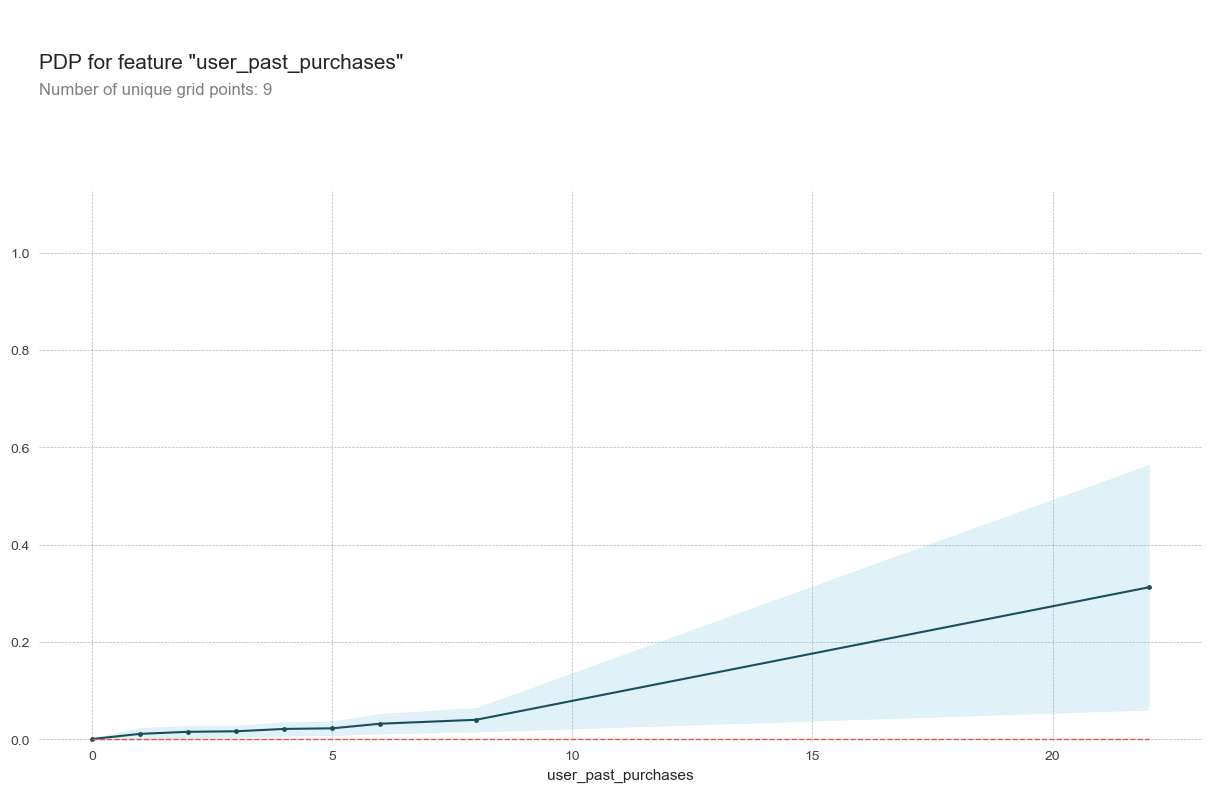

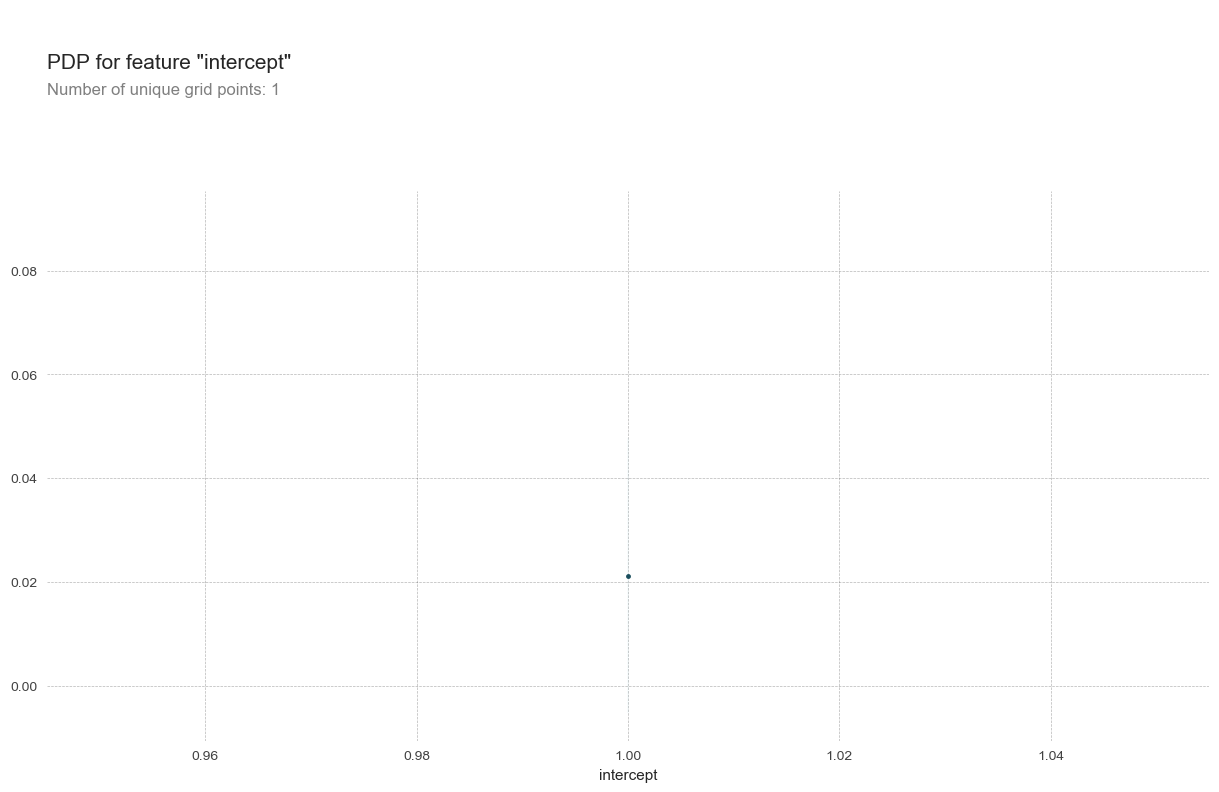

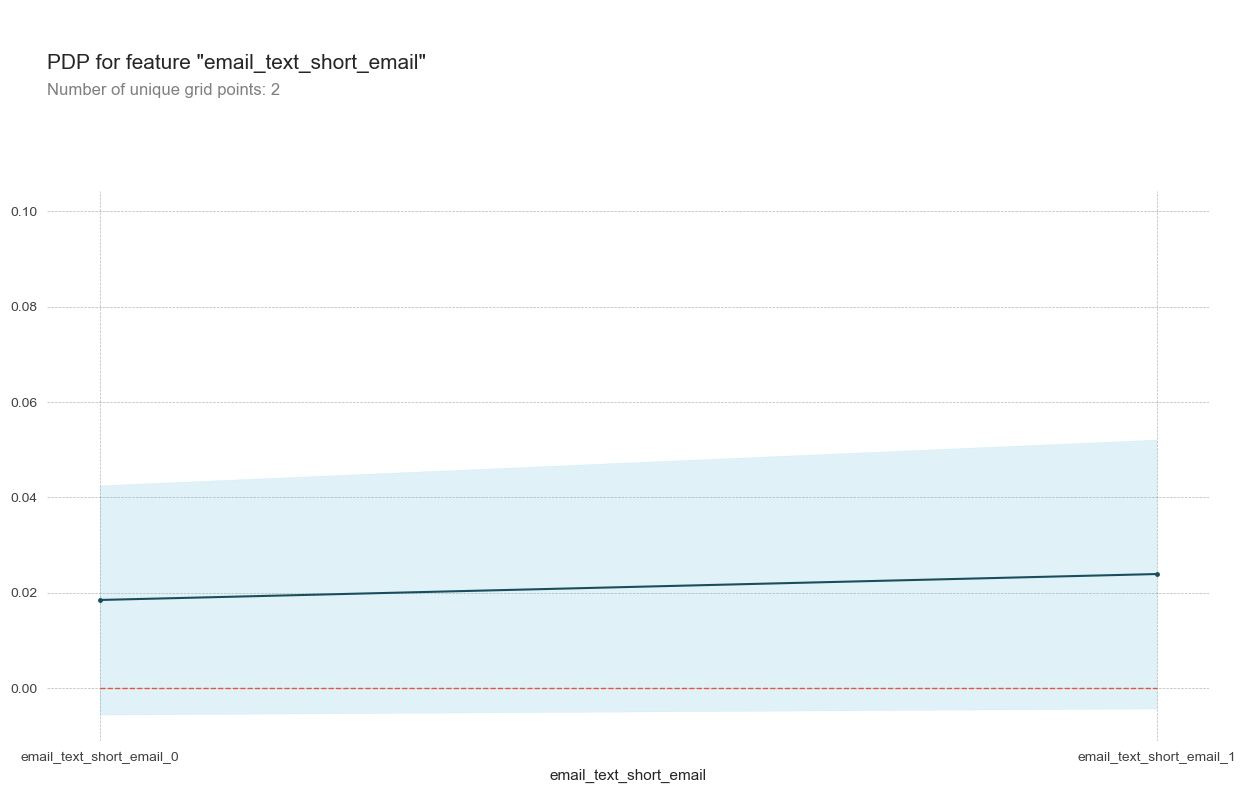

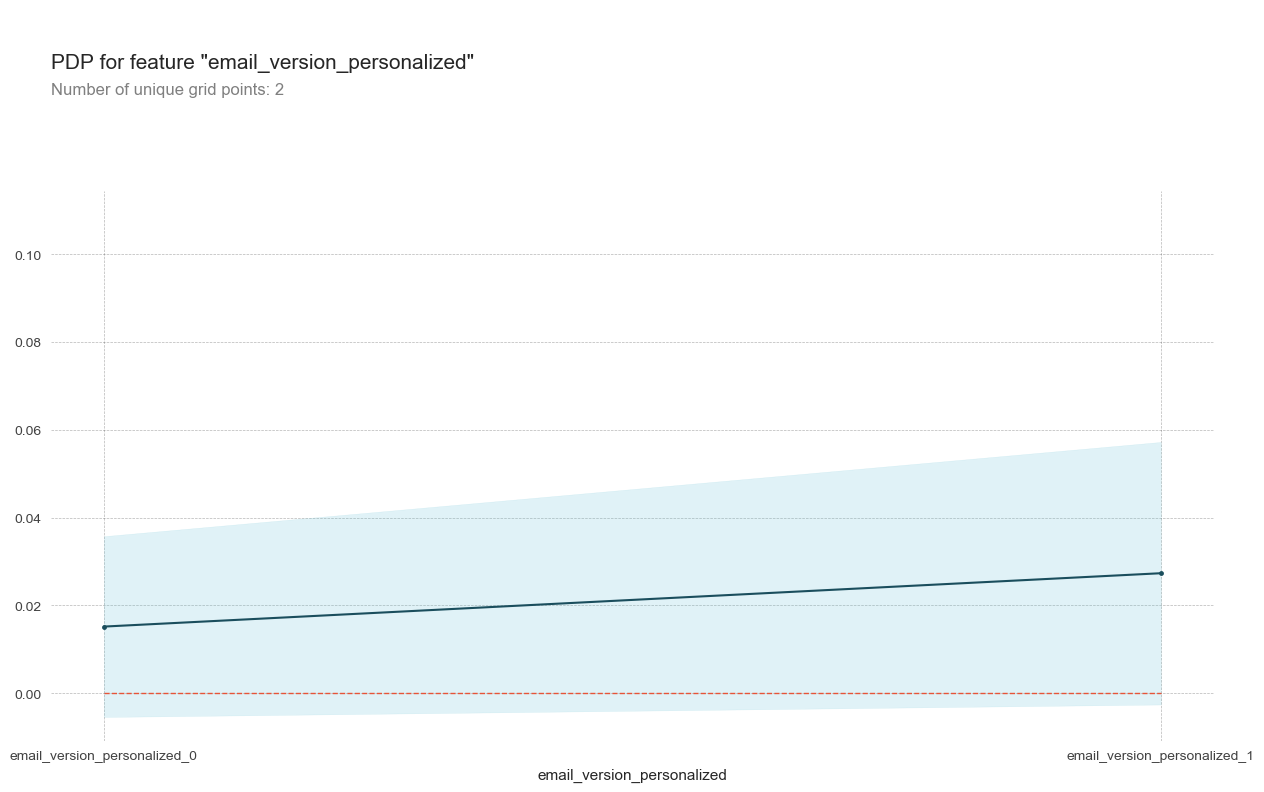

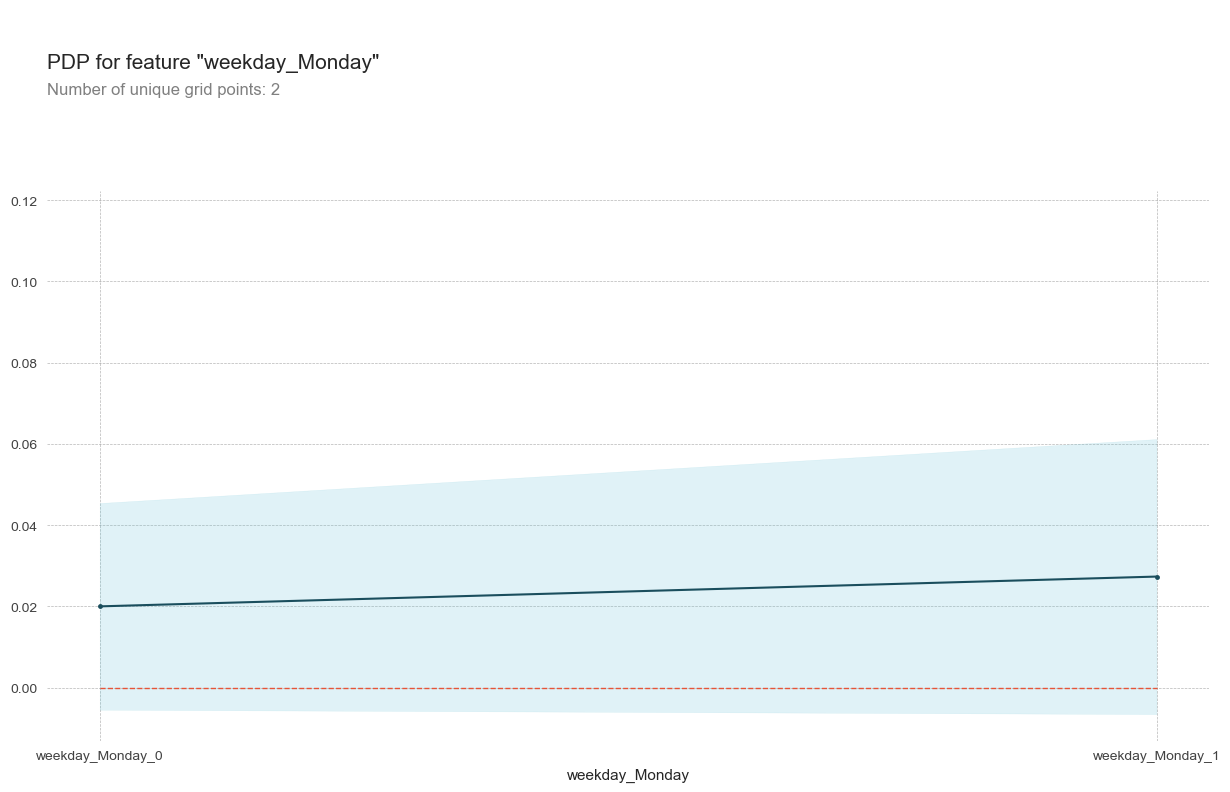

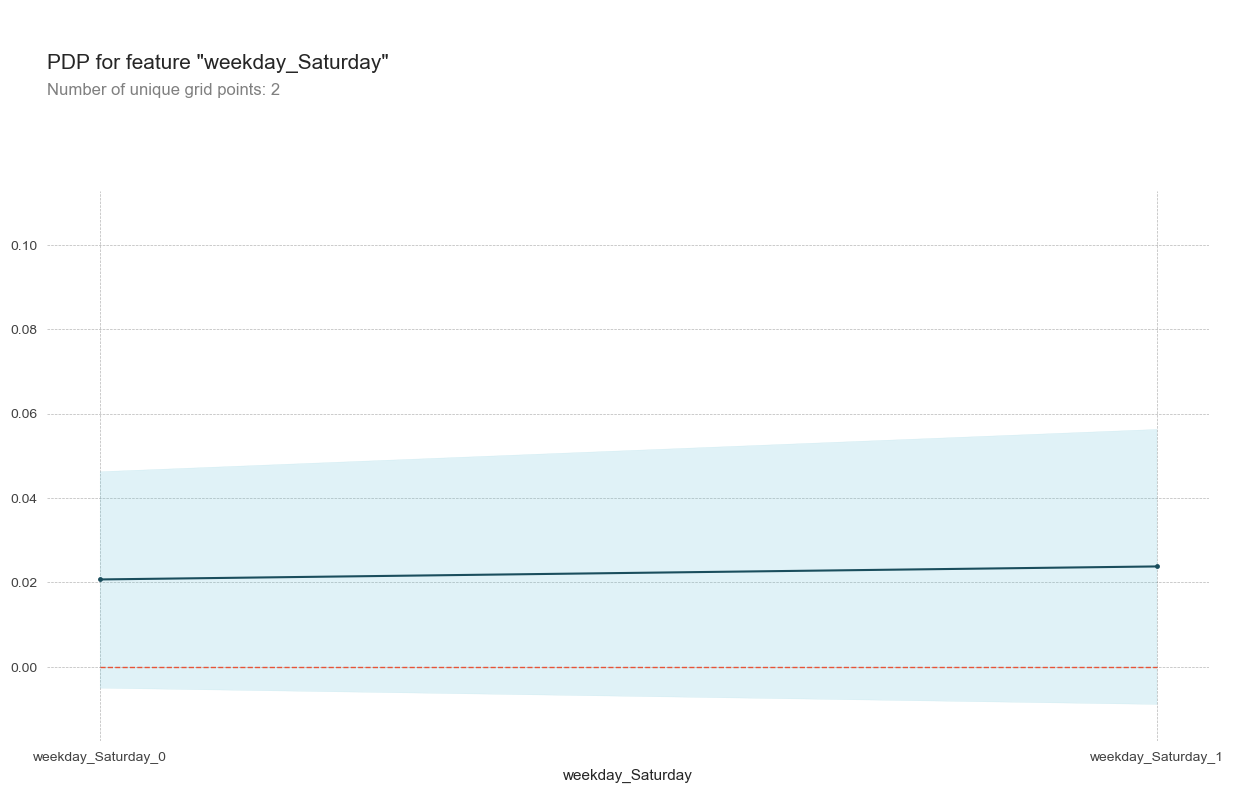

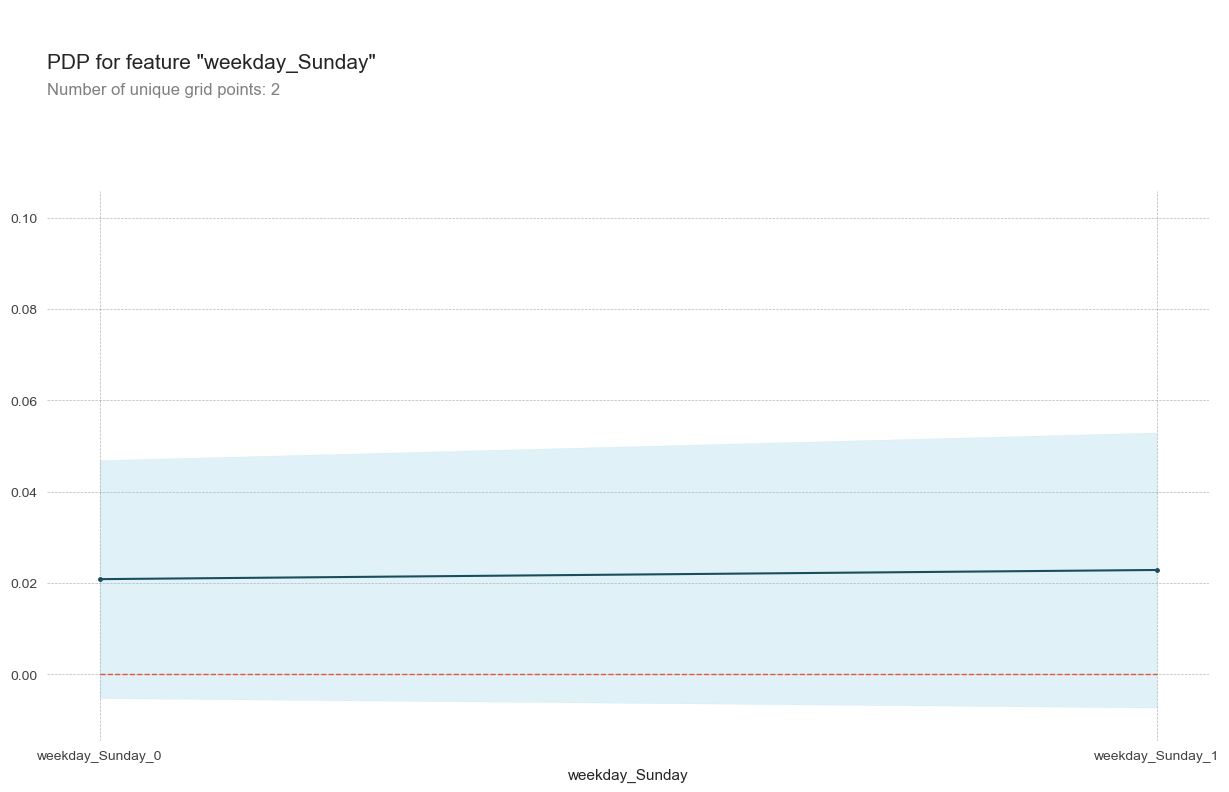

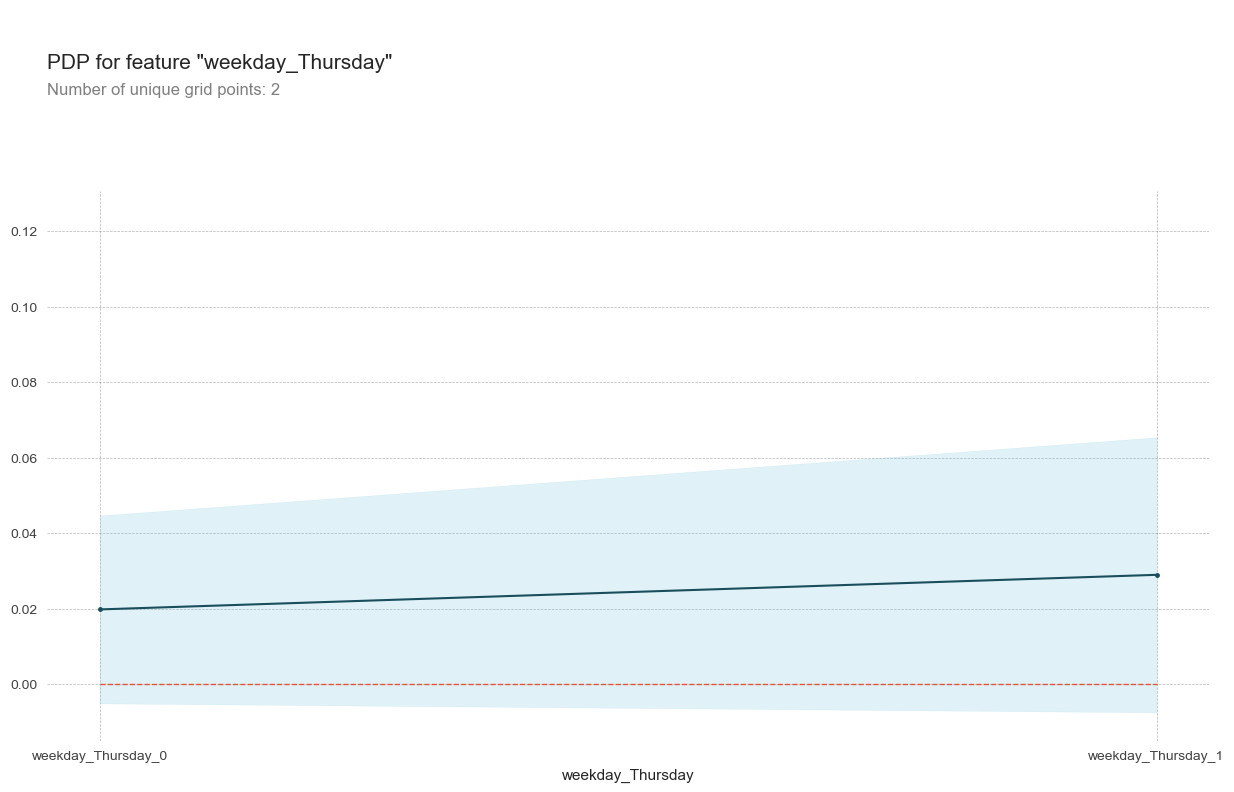

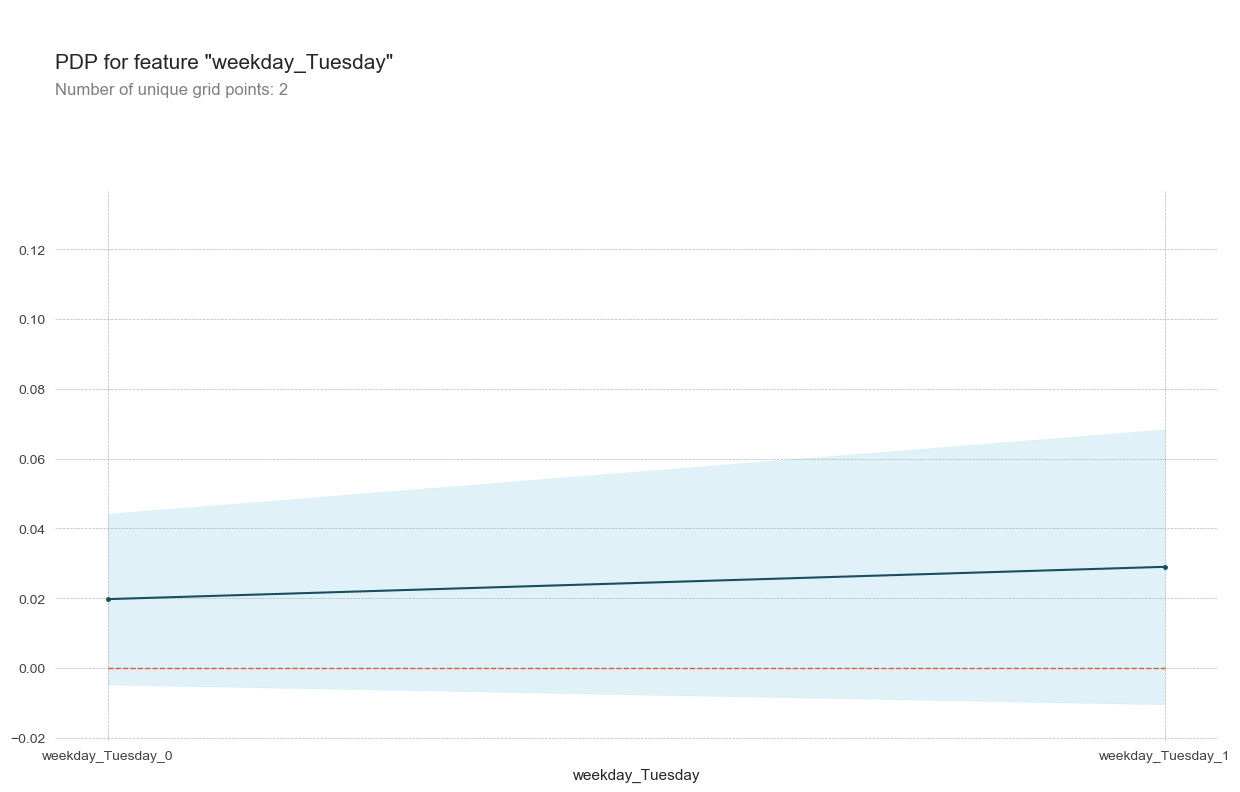

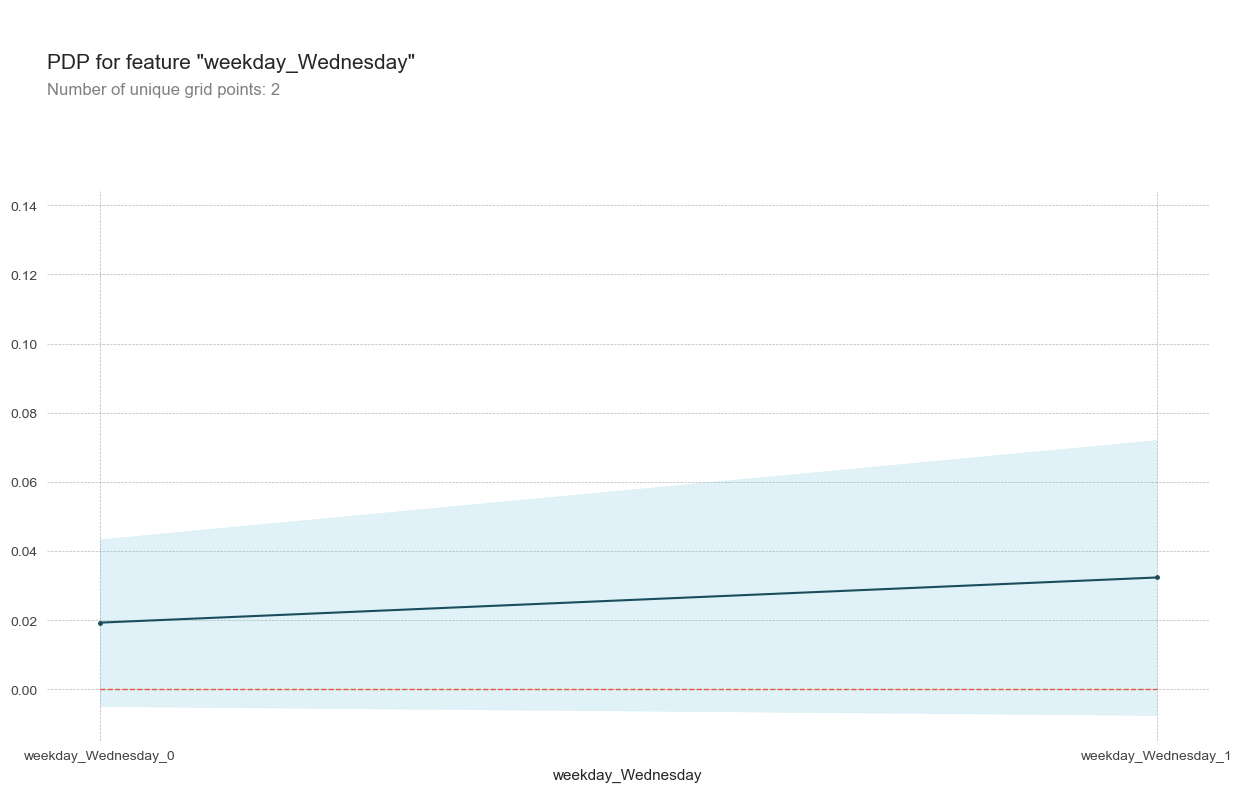

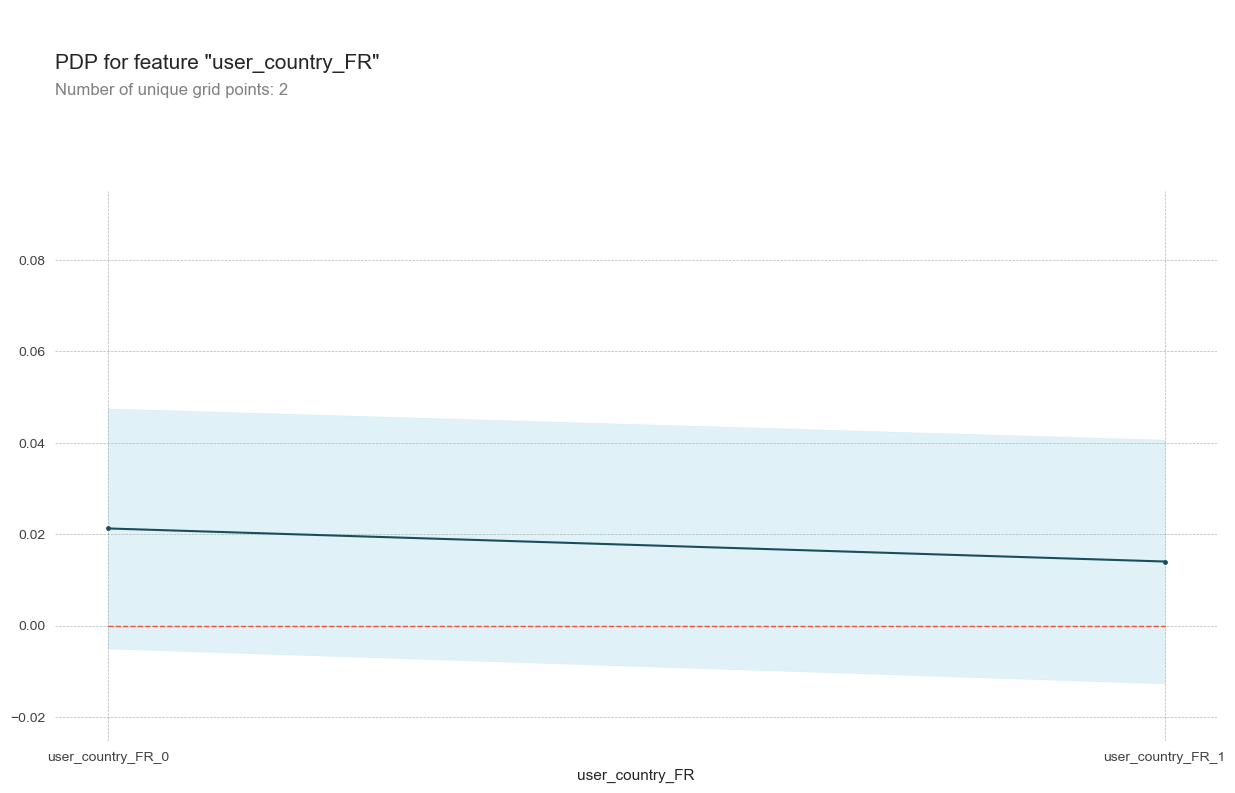

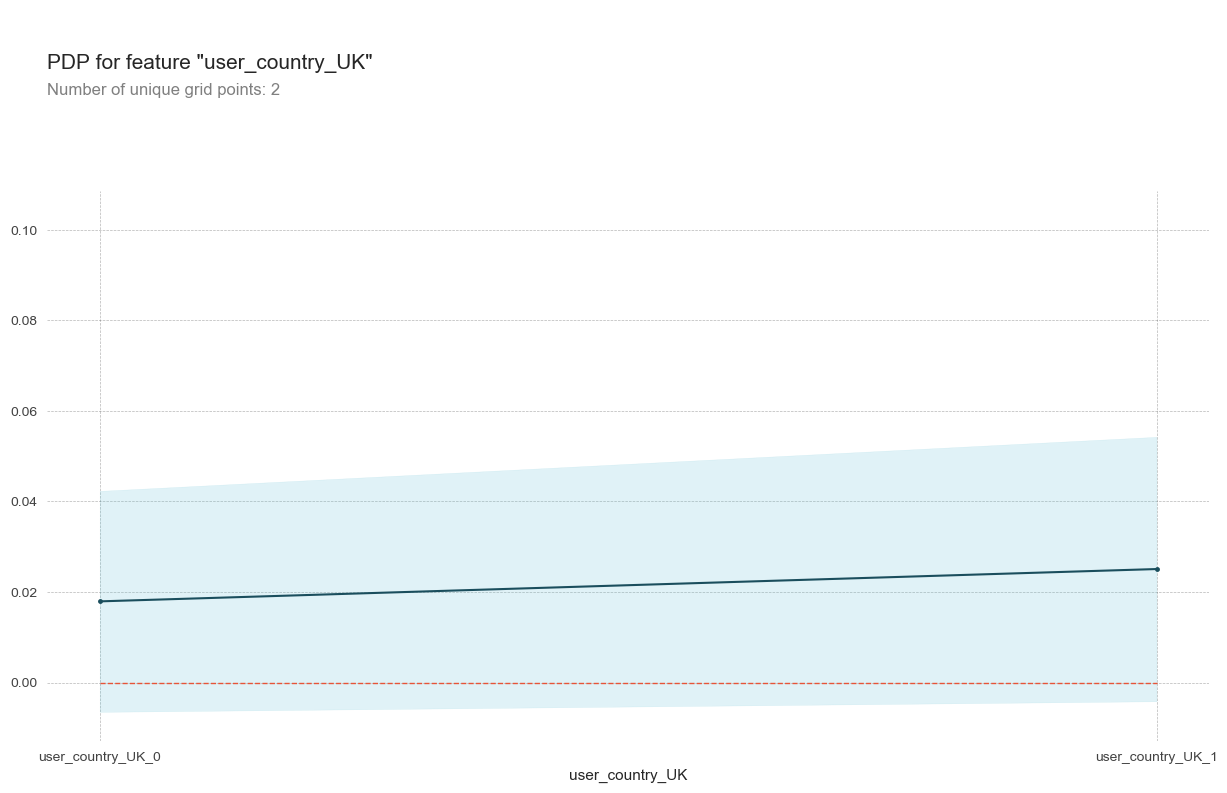

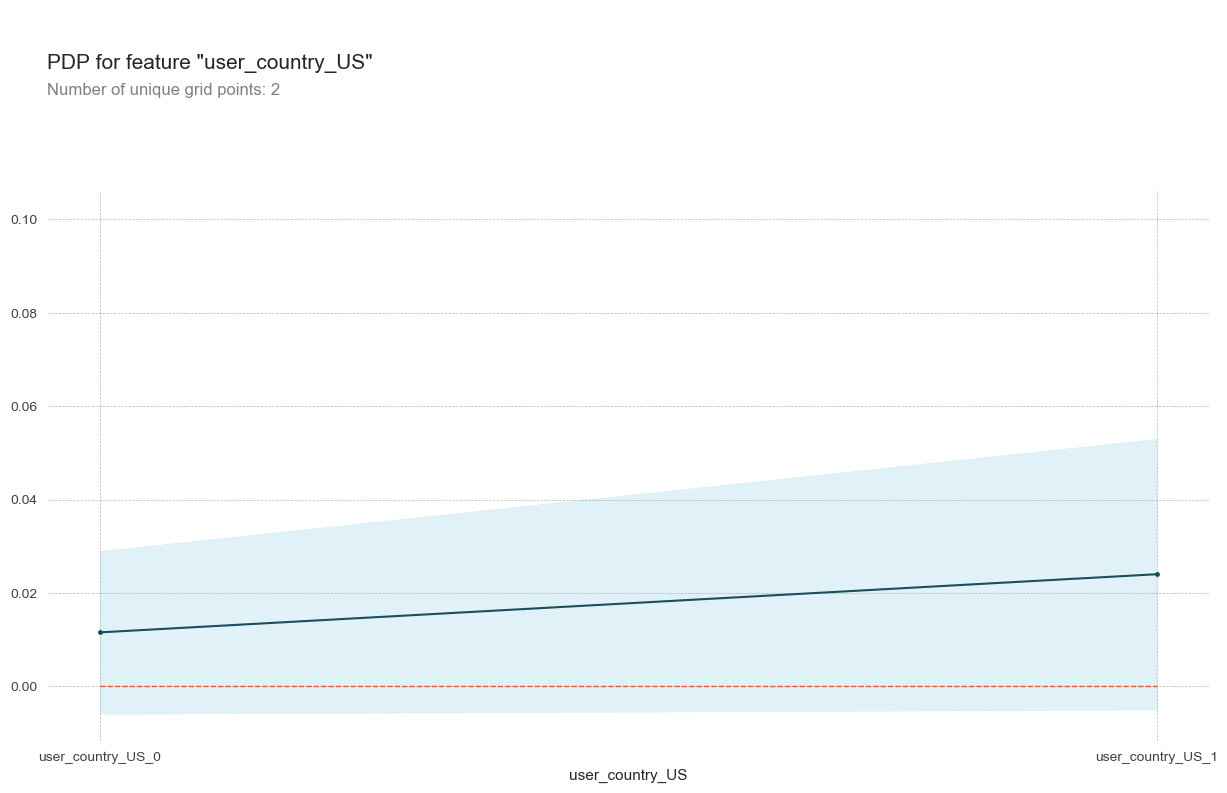

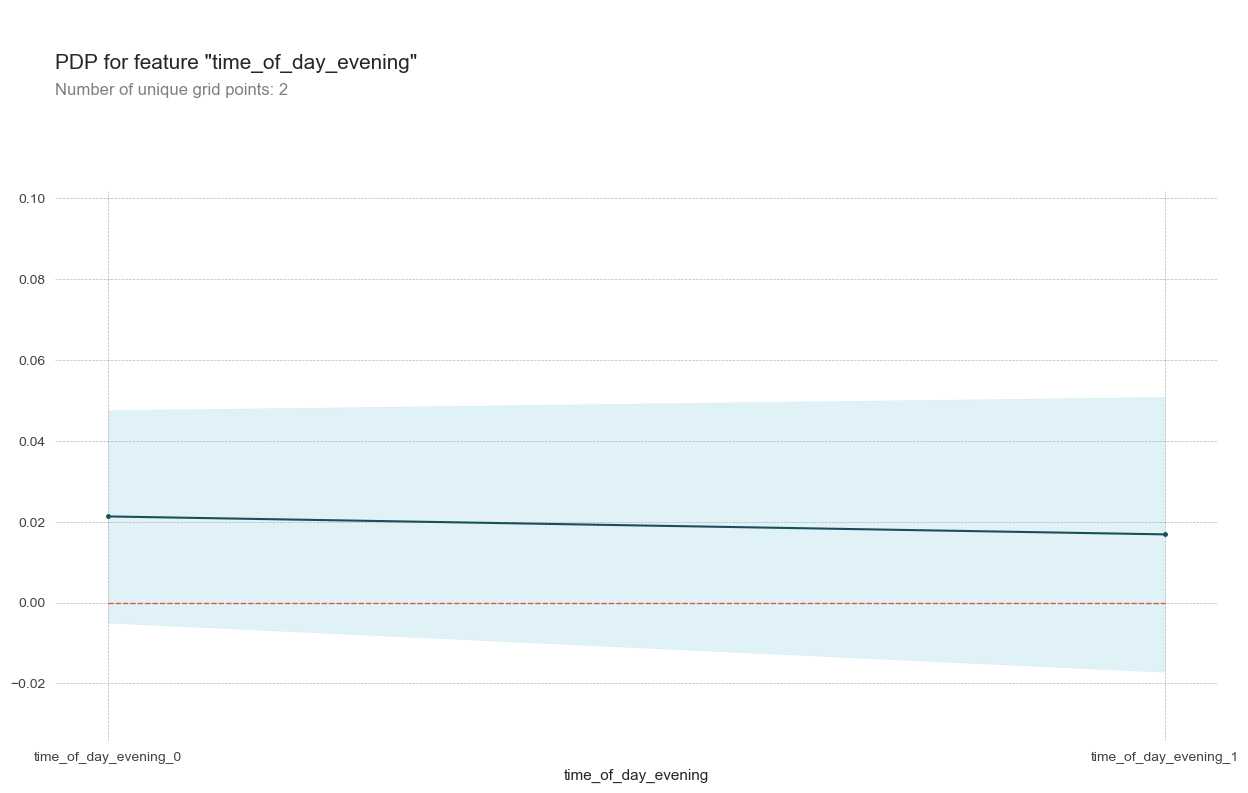

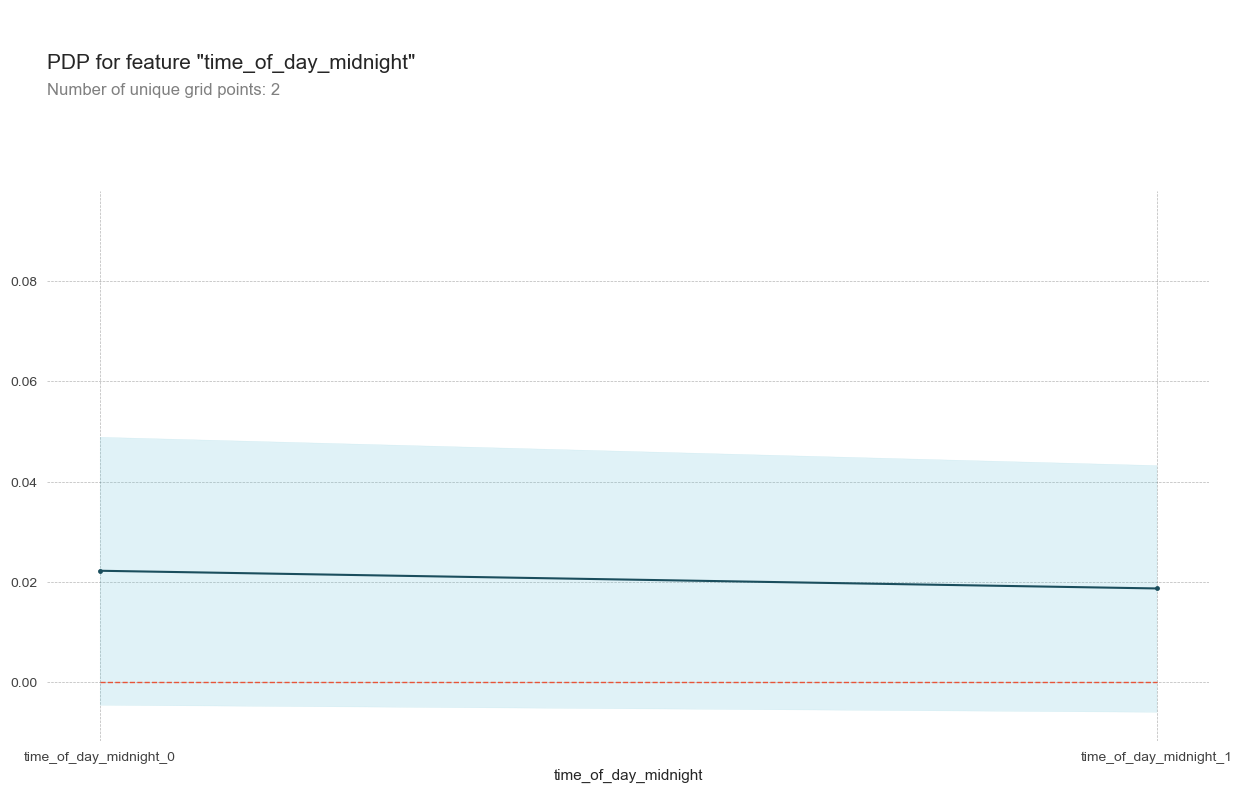

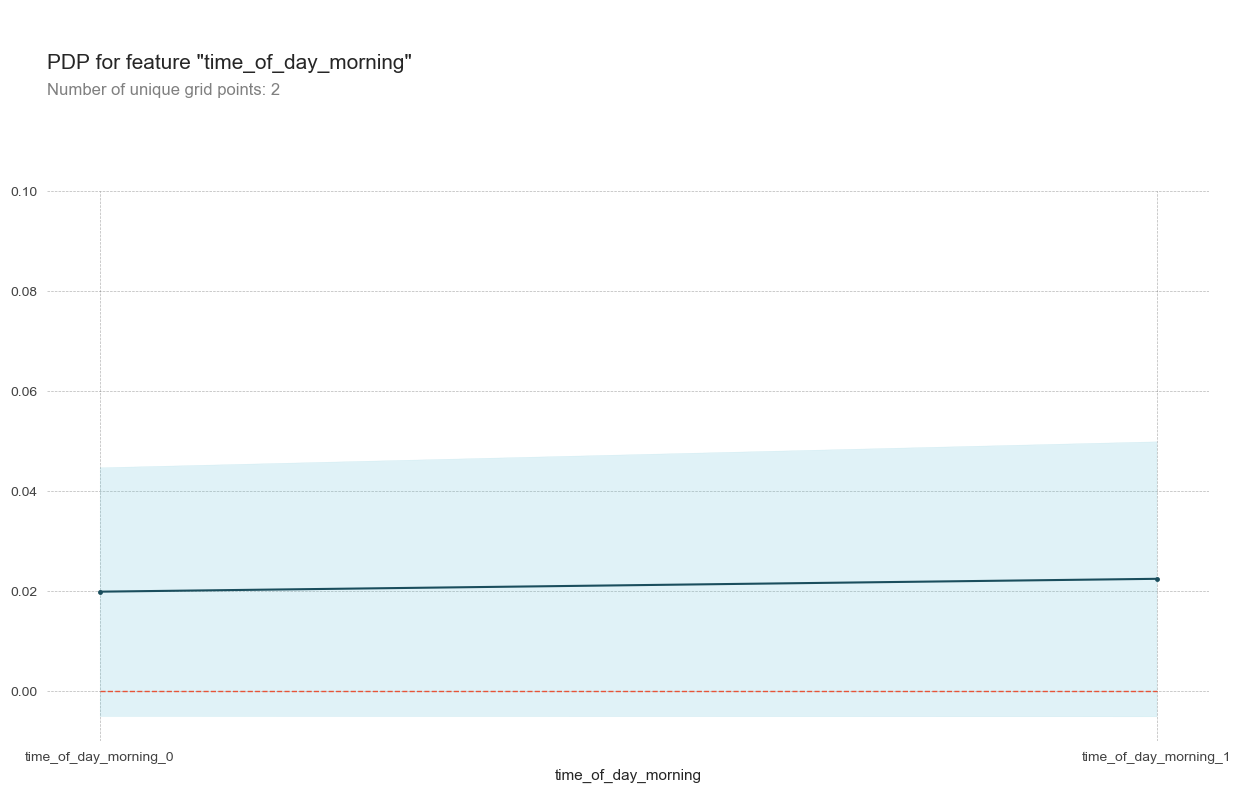

In [830]:
from pdpbox import pdp, info_plots

feat_original = X_dummies.columns
train_cols = X_dummies

# Iterate over all features in X
for feat in feat_original:
  # Create a PDP plot for the current feature
  pdp_version = pdp.pdp_isolate(model=xgb,
                              dataset=train_cols,
                              model_features=list(train_cols),
                              feature=feat)
  # Plot the PDP plot for the current feature
  pdp.pdp_plot(pdp_version, feat, center=False)

**Insights**:
* Personalized and short email campaigns have been found to be more effective in driving engagement and conversions, according to PDP charts. This aligns with our previous findings that morning and afternoon are generally better times to send emails compared to midnight and evening.

* Our data suggests that there is a positive correlation between the number of products a user has purchased and their likelihood of clicking on an email campaign. This could indicate that customers who have previously made a purchase are more engaged with the brand and more likely to respond to marketing efforts.

* Analysis of user country data shows that email campaigns targeted towards users in the US and UK tend to perform better than those targeted towards users in France and Spain. This could be due to cultural differences in email engagement or variations in the marketing strategies of the brand in different regions.

* Monday through Thursday have been found to be significantly more effective days for sending email campaigns compared to Friday and the weekend. This could be due to the fact that individuals tend to be more focused on work and personal responsibilities during the week, making them more likely to engage with marketing emails.

## Rule Fit

In [839]:
from sklearn.ensemble import RandomForestClassifier
from rulefit import RuleFit
from sklearn.linear_model import LogisticRegression

feat_original = X_dummies.columns
train_cols = X_dummies

rf = RandomForestClassifier(max_depth=2,n_estimators = 10,class_weight={0:0.05,1:0.95})

rufi = RuleFit(rfmode='classify', 
               #classify for binary;regressor for regression
              tree_generator=rf,
              exp_rand_tree_size=False,
              lin_standardise=False)
rufi.fit(train_cols.values,
         y.values,
         feature_names=train_cols.columns)
print('we have extracted', rufi.transform(train_cols.values).shape[1],
     'rules')

output = rufi.get_rules()

X_concat = np.concatenate((train_cols,
                          rufi.transform(train_cols.values)),
                          axis = 1)
log = LogisticRegression(penalty='l1',
                         solver='liblinear',
                         C=0.1)
log.fit(X_concat,y)

output.iloc[:,2] = np.transpose(log.coef_)

output[output['coef']!=0].sort_values('coef',ascending=False)

we have extracted 38 rules


,rule,type,coef,support,importance
11,user_country_UK,linear,0.896237,1.000000,0.00000
37,email_version_personalized > 0.5 & user_country_US > 0.5,rule,0.327706,0.298439,0.00000
8,weekday_Tuesday,linear,0.323421,1.000000,0.00000
4,weekday_Monday,linear,0.245758,1.000000,0.00000
0,user_past_purchases,linear,0.139220,1.000000,1.01102
31,time_of_day_morning > 0.5 & weekday_Wednesday > 0.5,rule,0.099502,0.064891,0.00000
52,email_version_personalized > 0.5 & email_text_short_email > 0.5,rule,0.095006,0.247719,0.00000
15,time_of_day_morning,linear,0.063849,1.000000,0.00000
18,user_past_purchases > 0.5 & user_past_purchases <= 5.5,rule,-0.000161,0.588084,0.00000
40,user_country_FR <= 0.5 & user_country_US <= 0.5,rule,-0.001792,0.298915,0.00000


**Insights**:
* User country is an important feature for predicting the likelihood of customers clicking on the link within an email. Users from UK have the highest coefficient and users from France have the lowest coefficient.
* Personalized email and short email text are positively correlated with click-through rate (CTR). The rule "email_version_personalized > 0.5 & email_text_short_email > 0.5" has a positive coefficient of 0.095006 and high support (24.77%).
* Weekdays, specifically Monday and Tuesday, have positive coefficients and high support, indicating that they are positively correlated with CTR.
* Past purchases history of the user is also positively correlated with CTR. The feature "user_past_purchases" has a positive coefficient of 0.139220 and high support (1.000000).
* Morning time of day is positively correlated with CTR and evening time of day is negatively correlated with CTR.
* Combinations of features also show positive or negative correlation with the CTR, such as "time_of_day_morning > 0.5 & weekday_Wednesday > 0.5" or "time_of_day_evening > 0.5 & user_country_FR > 0.5".
* Many rules have negative coefficient and high support, indicating that those features or combinations of features are negatively correlated with CTR.
* The intercept has a negative coefficient of -2.070982, which suggests that overall, the model predicts a negative conversion rate.

# 4. Click Prediction Model

**First pick a few models out of these models**
- Logistic
- SVM
- KNN
- Random Forests
- XG Boosting
- Neural Network

In [854]:
# Important Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    f1_score,
    roc_auc_score,
    recall_score,
    accuracy_score,
)

from sklearn.model_selection import cross_validate

<span class="mark">**Note**:</span>
* The Area Under the ROC Curve (AUC) is a measure that quantifies the model's ability to distinguish between the two classes of the target variable. A higher AUC indicates that the model is able to make more accurate predictions.
* The ROC AUC curve is particularly useful when the data is imbalanced, as it allows us to evaluate the model's ability to correctly identify both the positive and negative classes of the target variable.

In [983]:
models = {'Logit':LogisticRegression(),
        'KNN':KNeighborsClassifier(),
        'RF':RandomForestClassifier(),
        'XG':XGBClassifier()}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    score = cross_validate(estimator=model, X=X_dummies, y=y, scoring=['roc_auc'], cv=cv)
    results[name] = {
    'roc_auc': score['test_roc_auc']
    }


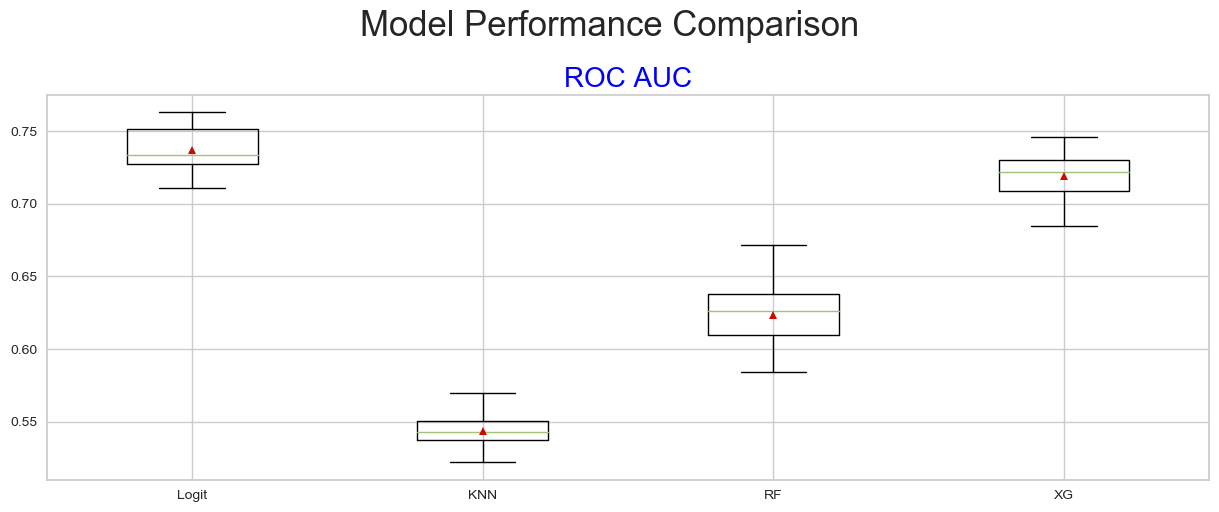

In [916]:
def plot_performance():
    roc_auc = [result['roc_auc'] for result in results.values()]
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.suptitle("Model Performance Comparison", fontsize=25,y=1.05)
    ax.boxplot(roc_auc, labels=results.keys(), showmeans=True)
    ax.set_title("ROC AUC", size=20, color='blue')
plot_performance()


we can see that Logistic Regression performs relatively well. Let's pick Logistic Regression and fine tune it

Let's tuning it

In [921]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distributions
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 10, 100, 200],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'max_iter': [100, 500, 1000]
}

# Create a logistic regression model
logreg = LogisticRegression()

# Create the randomized search object
random_search = RandomizedSearchCV(logreg,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=5,
                                   random_state=42)

# Fit the randomized search object to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.001, 0.01, 10, 100, 200],
                                        'max_iter': [100, 500, 1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag']},
                   random_state=42)

In [922]:
random_search.best_estimator_

LogisticRegression(C=0.01, max_iter=1000, solver='newton-cg')

In [923]:
random_search.best_score_

0.979175

**Refit the model**

In [924]:
model = LogisticRegression(C=0.01,
                  max_iter=1000,
                  solver='newton-cg').fit(X_dummies,y)

Thank you! Please let me know if you have any questions!